# Convolutional neural networks 101

Convolution neural networks are one of the most successful types of neural networks for image recognition and an integral part of reigniting the interest in neural networks. They are able to extract structural relations in the data, such as spatial in images or temporal in time series.

In this lab, we will experiment with inserting 2D-convolution layers in the fully connected neural networks introduced previously. We will also try to visualize the learned convolution filters and try to understand what kind of features they learn to recognize.

If you have not watched Jason Yosinski's [video on visualizing convolutional networks](https://www.youtube.com/watch?v=AgkfIQ4IGaM), you definitely should do so now. If you are unfamiliar with the convolution operation, [Vincent Dumoulin](https://github.com/vdumoulin/conv_arithmetic) has a nice visualization of different convolution variants. For a more in-depth tutorial, please see http://cs231n.github.io/convolutional-networks/ or http://neuralnetworksanddeeplearning.com/chap6.html.

## Reminder: what are convolutional networks?

Standard ConvNets are, in many respects, very similar to the dense feedforward networks we saw previously:
 * The network is still organized into layers.
 * Each layer is parameterized by weights and biases.
 * Each layer has an element-wise non-linear transformation (activation function).
 * There are no cycles in the connections (more on this in later labs).

*So what is the difference?*
The networks we saw previously are called *dense* because each unit receives input from all the units in the previous layer. This is not the case for ConvNets. In ConvNets each unit is only connected to a small subset of the input units. This is called the *receptive field* of the unit.

#### Example
The input (green matrix) is a tensor of size `1x5x5` -- i.e. it has one "channel" (like a grayscale image), and the feature map has size `5x5`. Let us define a `1x3x3` kernel (yellow submatrix). The kernel weights are indicated in red at the bottom right of each element. The computation can be thought of as an elementwise multiplication followed by a sum. Here we use a *stride* of 1, as shown in this animation:

<img src="https://raw.githubusercontent.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/master/4_Convolutional/images/convolutions.gif" style="width: 400px;"/>

GIF courtesy of [Stanford](http://deeplearning.stanford.edu/wiki/index.php/Feature_extraction_using_convolution)

After having convolved the image, we perform an elementwise non-linear transformation on the *convolved features*.
In this example, the input is a 2D *feature map* with depth 1.


# Assignment 1

### Assignment 1.1: Manual calculations

Perform the following computation, and write the result below.

![](https://raw.githubusercontent.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/master/4_Convolutional/images/conv_exe.png)

1. Manually convolve the input, and compute the convolved features. No padding and stride of 1.
 * **Answer:**
2. Perform `2x2` max pooling on the convolved features. Stride of 2.
 * **Answer:**

### Assignment 1.2: Output dimensionality

Given the following 3D tensor input `(channel, height, width)`, a given amount (`channels_out`) of filters `(channels_in, filter_height, filter_width)`, stride `(height, width)` and padding `(height, width)`, calculate the output dimensionality if it is valid.

1. input tensor with dimensionality (1, 28, 28) and 16 filters of size (1, 5, 5) with stride (1, 1) and padding (0, 0)
 * **Answer:** 
2. input tensor with dimensionality (2, 32, 32) and 24 filters of size (2, 3, 3) with stride (1, 1) and padding (0, 0)
 * **Answer:** 
3. input tensor with dimensionality (10, 32, 32) and 3 filters of size (10, 2, 2) with stride (2, 2) and padding (0, 0)
 * **Answer:** 
4. input tensor with dimensionality (11, 8, 16) and 7 filters of size (11, 3, 3) with stride (2, 2) and padding (1, 1)
 * **Answer:** 
5. input tensor with dimensionality (128, 256, 256) and 112 filters of size (128, 3, 3) with stride (1, 1) and padding (1, 1)
 * **Answer:** 
 

# Load packages

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import accuracy_score
from torch.utils.data import TensorDataset, DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
sns.set_style("whitegrid")


# Load MNIST data

The code below downloads and loads the same MNIST dataset as before.
Note however that the data has a different shape this time: `(num_samples, num_channels, height, width)`.

In [10]:
# Download the MNIST dataset, if you have not already.
!if [ ! -f mnist.npz ]; then wget -N https://www.dropbox.com/s/qxywaq7nx19z72p/mnist.npz; else echo "mnist.npz already downloaded"; fi

! was unexpected at this time.


In [11]:
# Load the MNIST data. 

# Note that we reshape the data from:
#   (nsamples, num_features) = (nsamples, channels * height * width)
# to:
#   (nsamples, channels, height, width)
# in order to retain the spatial arrangements of the pixels.

data = np.load('mnist.npz')
channels, height, width = 1, 28, 28


def get_data(split, size):
    x = data[f"X_{split}"][:size].astype('float32')
    x = x.reshape((-1, channels, height, width))
    targets = data[f"y_{split}"][:size].astype('int64')
    return torch.from_numpy(x), torch.from_numpy(targets)


x_train, targets_train = get_data('train', 50000)
x_valid, targets_valid = get_data('valid', 2000)
x_test, targets_test = get_data('test', 5000)

num_classes = len(np.unique(targets_train))

print("Information on dataset")
print("Shape of x_train:", x_train.shape)
print("Shape of targets_train:", targets_train.shape)
print("Shape of x_valid:", x_valid.shape)
print("Shape of targets_valid:", targets_valid.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of targets_test:", targets_test.shape)

Information on dataset
Shape of x_train: torch.Size([50000, 1, 28, 28])
Shape of targets_train: torch.Size([50000])
Shape of x_valid: torch.Size([2000, 1, 28, 28])
Shape of targets_valid: torch.Size([2000])
Shape of x_test: torch.Size([5000, 1, 28, 28])
Shape of targets_test: torch.Size([5000])


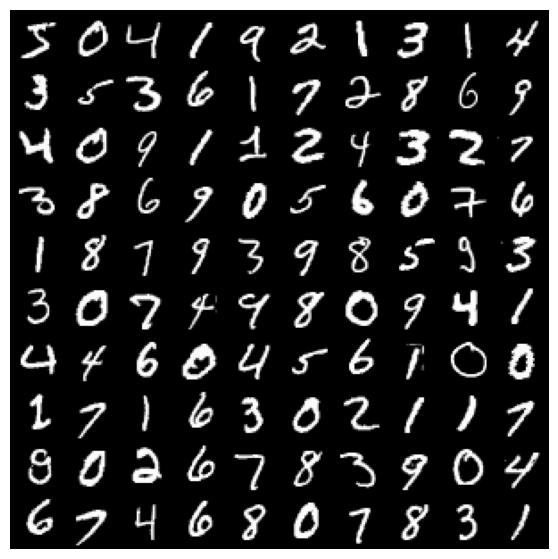

In [12]:
# Plot a few MNIST examples
plt.figure(figsize=(7, 7))
plt.imshow(make_grid(x_train[:100], nrow=10).permute(1, 2, 0))
plt.axis('off')
plt.show()

# Define a simple feed forward neural network

In [13]:
assert (channels, height, width) == x_train.shape[1:]
n_features = channels * height * width


class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first forward pass."""
    
    first = True
    
    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x


class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        activation_fn = nn.ReLU

        self.net = nn.Sequential(
            nn.Flatten(),  # from (1, channels, height, width) to (1, channels * height * width)
            nn.Linear(n_features, 128),
            activation_fn(),
            nn.Linear(128, 128),
            activation_fn(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)


model = Model()
print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


Model(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [14]:
# Test the forward pass with dummy data
out = model(torch.randn(2, 1, 28, 28))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().numpy()}")

Output shape: torch.Size([2, 10])
Output logits:
[[-0.21996108  0.06643356  0.1615724  -0.04819433 -0.00500407  0.08737141
   0.00497659 -0.13210015 -0.01291312 -0.11645418]
 [-0.18267214 -0.0510111  -0.01336798 -0.08252247 -0.1620754   0.05954044
  -0.12185857 -0.02014157  0.02466691 -0.07894516]]
Output probabilities:
[[0.08152401 0.10855883 0.11939426 0.09680168 0.10107417 0.11085578
  0.10208801 0.08901088 0.10027792 0.09041449]
 [0.08846194 0.10091045 0.10478143 0.0977802  0.09030285 0.11270626
  0.09400856 0.10407408 0.10884354 0.09813061]]


# Train network

In [15]:
batch_size = 64
num_epochs = 5
validation_every_steps = 500

train_set = TensorDataset(x_train, targets_train)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
valid_set = TensorDataset(x_valid, targets_valid)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, drop_last=False)
test_set = TensorDataset(x_test, targets_test)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=False)

step = 0
model.train()

train_accuracies = []
valid_accuracies = []
        
for epoch in range(num_epochs):
    
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        
        # Forward pass.
        output = model(inputs)
        
        # Compute loss.
        loss = loss_fn(output, targets)
        
        # Clean up gradients from the model.
        optimizer.zero_grad()
        
        # Compute gradients based on the loss from the current batch (backpropagation).
        loss.backward()
        
        # Take one optimizer step using the gradients computed in the previous step.
        optimizer.step()
        
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy_score(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in valid_loader:
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy_score(targets, predictions) * len(inputs))

                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(x_valid))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             validation accuracy: {valid_accuracies[-1]}")

print("Finished training.")

Step 500     training accuracy: 0.87665625
             validation accuracy: 0.933
Step 1000    training accuracy: 0.9491295662100456
             validation accuracy: 0.947
Step 1500    training accuracy: 0.95853125
             validation accuracy: 0.9645
Step 2000    training accuracy: 0.9714968607305936
             validation accuracy: 0.965
Step 2500    training accuracy: 0.9792993630573248
             validation accuracy: 0.96
Step 3000    training accuracy: 0.978125
             validation accuracy: 0.9635
Step 3500    training accuracy: 0.982671210106383
             validation accuracy: 0.9665
Finished training.


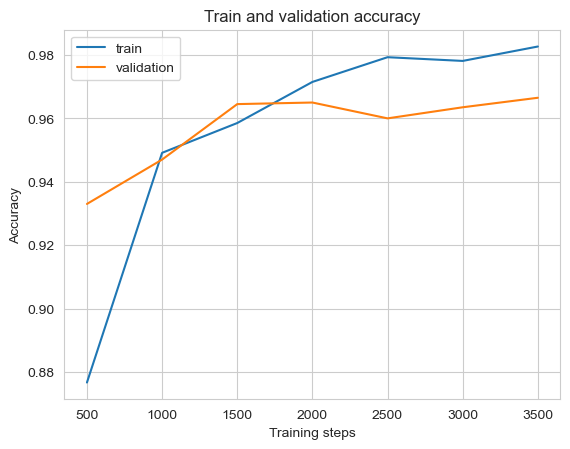

Validation accuracy: 0.967
Test accuracy: 0.963


In [16]:
steps = (np.arange(len(train_accuracies), dtype=int) + 1) * validation_every_steps

plt.figure()
plt.plot(steps, train_accuracies, label='train')
plt.plot(steps, valid_accuracies, label='validation')
plt.xlabel('Training steps')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Train and validation accuracy")
plt.show()

# Evaluate test set
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy_score(targets, predictions) * len(inputs))

    test_accuracy = np.sum(test_accuracies) / len(x_test)
    print(f"Validation accuracy: {valid_accuracies[-1]:.3f}")
    print(f"Test accuracy: {test_accuracy:.3f}")
    
    model.train()


### Assignment 2

1. Note the performance of the standard feedforward neural network. Add a [2D convolution layer](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) before the first layer. Insert the utility module `PrintSize` to check the size of the tensor at any point in `Sequential`, and notice that the size of the image reduces after the convolution. This can cause loss of information, and can be avoided by using adequate padding in the convolutional layer.
  Does adding a convolutional layer increase the generalization performance of the network (try num_filters=32 and filter_size=5 as a starting point)?
  
2. Can the performance be increases even further by stacking more convolution layers?

3. We now have a deeper network than the initial simple feedforward network. What happens if we replace all convolutional layers with linear layers? Is this deep feedforward network performing as well as the convolutional one?
 
4. Max-pooling is a technique for decreasing the spatial resolution of an image while retaining the important features. Effectively this gives a local translational invariance and reduces the computation by a factor of four. In the classification algorithm which is usually desirable. You can either: 
 
   - add a maxpool layer (see the PyTorch docs, and try with kernel_size=2 and stride=2) after the convolution layer, or
   - add stride=2 to the arguments of the convolution layer directly.
     
  Verify that this decreases the spatial dimension of the image (insert a `PrintSize` module in the `Sequential`). Does this increase the performance of the network? Note that, to increase performance, you may need to stack multiple layers, increase the number of filters, or tune the learning rate.

5. Dropout is a very useful technique for preventing overfitting. Try to add a DropoutLayer after some of the convolution layers. You may observe a higher validation accuracy but lower train accuracy. Can you explain why this might be the case?
 
6. Batch normalization may help convergence in larger networks as well as generalization performance. Try to insert batch normalization layers into the network.


Again, if you didn't already, you really should [watch this video](https://www.youtube.com/watch?v=AgkfIQ4IGaM).

# Question
1. Note the performance of the standard feedforward neural network. Add a [2D convolution layer](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) before the first layer. Insert the utility module `PrintSize` to check the size of the tensor at any point in `Sequential`, and notice that the size of the image reduces after the convolution. This can cause loss of information, and can be avoided by using adequate padding in the convolutional layer.
  Does adding a convolutional layer increase the generalization performance of the network (try num_filters=32 and filter_size=5 as a starting point)?

## The model

In [155]:


assert (channels, height, width) == x_train.shape[1:]

# Definer hyperparametre
num_filters = 10
filter_size = 5
channels = 1  # input channels
height = 28
width = 28
num_classes = 10  
padding = 2

# Calculate output size after convolutional layer
output_height = (height - filter_size+ 2*padding) + 1  # 24
output_width = (width - filter_size + 2*padding) + 1    # 24
n_features = num_filters * output_height * output_width  # 32 * 24 * 24 = 18432

class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first forward pass."""
    def __init__(self):
        super(PrintSize, self).__init__()
        self.first = True
        
    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x

class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        activation_fn = nn.ReLU

        self.net = nn.Sequential(
            PrintSize(),
            nn.Conv2d(in_channels=channels, out_channels=num_filters, kernel_size=filter_size, padding=padding),
            activation_fn(),
            PrintSize(),
            nn.Flatten(),  # Konverterer (batch_size, channels, height, width) til (batch_size, channels * height * width)
            nn.Linear(n_features, 128),
            activation_fn(),
            nn.Linear(128, 128),
            activation_fn(),
            nn.Linear(128, num_classes),
            
        )

    def forward(self, x):
        
        return self.net(x)

model = Model()
print(model)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Model(
  (net): Sequential(
    (0): PrintSize()
    (1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (2): ReLU()
    (3): PrintSize()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=7840, out_features=128, bias=True)
    (6): ReLU()
    (7): Linear(in_features=128, out_features=128, bias=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=10, bias=True)
  )
)


## Dummy data


In [61]:
# Test the forward pass with dummy data
out = model(torch.randn(2, 1, 28, 28))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().numpy()}")

Size: torch.Size([2, 1, 28, 28])
Size: torch.Size([2, 32, 24, 24])
Output shape: torch.Size([2, 10])
Output logits:
[[-0.09683696  0.02272422 -0.0535202  -0.06065464 -0.01527571  0.00777549
   0.05393604  0.07817297 -0.03223662  0.03169893]
 [-0.08359674  0.01392702 -0.06647837 -0.10631499 -0.01222893  0.01664883
   0.06011479  0.04393406  0.00764266  0.0144431 ]]
Output probabilities:
[[0.09123038 0.10281684 0.09526902 0.09459175 0.09898311 0.10129128
  0.10607655 0.10867892 0.09731842 0.10374375]
 [0.09288701 0.10240213 0.09449077 0.09080056 0.09975843 0.10268123
  0.10724279 0.10552149 0.10176062 0.102455  ]]


## The loop


In [156]:
batch_size = 64
num_epochs = 5
validation_every_steps = 500

train_set = TensorDataset(x_train, targets_train)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
valid_set = TensorDataset(x_valid, targets_valid)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, drop_last=False)
test_set = TensorDataset(x_test, targets_test)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=False)

step = 0
model.train()

train_accuracies = []
valid_accuracies = []
        
for epoch in range(num_epochs):
    
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        
        # Forward pass.
        output = model(inputs)
        
        # Compute loss.
        loss = loss_fn(output, targets)
        
        # Clean up gradients from the model.
        optimizer.zero_grad()
        
        # Compute gradients based on the loss from the current batch (backpropagation).
        loss.backward()
        
        # Take one optimizer step using the gradients computed in the previous step.
        optimizer.step()
        
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy_score(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in valid_loader:
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy_score(targets, predictions) * len(inputs))

                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(x_valid))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             validation accuracy: {valid_accuracies[-1]}")

print("Finished training.")

Size: torch.Size([64, 1, 28, 28])
Size: torch.Size([64, 10, 28, 28])
Step 500     training accuracy: 0.9065625
             validation accuracy: 0.9655
Step 1000    training accuracy: 0.97574200913242
             validation accuracy: 0.9775
Step 1500    training accuracy: 0.9798125
             validation accuracy: 0.982
Step 2000    training accuracy: 0.9870505136986302
             validation accuracy: 0.9795
Step 2500    training accuracy: 0.9920382165605095
             validation accuracy: 0.9865
Step 3000    training accuracy: 0.99078125
             validation accuracy: 0.9775
Step 3500    training accuracy: 0.9947224069148937
             validation accuracy: 0.981
Finished training.


# **Num_filters = 32, filter_size = 5**
## Without convolution layer

### **Zero padding:**
1. Step 2500    training accuracy: 0.9792993630573248
             validation accuracy: 0.96
2. Step 3000    training accuracy: 0.978125
             validation accuracy: 0.9635
3. Step 3500    training accuracy: 0.982671210106383
             validation accuracy: 0.9665

## With convolution layer

### **Zero padding:** (Reduce the image size from 28x28 to 24x24)

1. Step 500     training accuracy: 0.9174375
             validation accuracy: 0.968
2. Step 1000    training accuracy: 0.9764554794520548
             validation accuracy: 0.9765
3. Step 1500    training accuracy: 0.97928125
             validation accuracy: 0.981
4. Step 2000    training accuracy: 0.9875142694063926
             validation accuracy: 0.9805
5. Step 2500    training accuracy: 0.9917396496815286
             validation accuracy: 0.9805
6. Step 3000    training accuracy: 0.99046875
             validation accuracy: 0.9835
7. Step 3500    training accuracy: 0.9945977393617021
             validation accuracy: 0.983



### **Padding = 1**  (Reduce the image size from 28x28 to 26x26)

1. Step 500     training accuracy: 0.91740625
             validation accuracy: 0.9705
2. Step 1000    training accuracy: 0.9808076484018264
             validation accuracy: 0.98
3. Step 1500    training accuracy: 0.98
             validation accuracy: 0.982
4. Step 2000    training accuracy: 0.9893336187214612
             validation accuracy: 0.983
5. Step 2500    training accuracy: 0.9930334394904459
             validation accuracy: 0.9815
6. Step 3000    training accuracy: 0.991875
             validation accuracy: 0.9825
7. Step 3500    training accuracy: 0.9947639627659575
             validation accuracy: 0.983

### **Padding = 2** (Does not reduce the size of the image)

1. Step 500     training accuracy: 0.91521875
             validation accuracy: 0.973
2. Step 1000    training accuracy: 0.9788099315068494
             validation accuracy: 0.971
3. Step 1500    training accuracy: 0.981875
             validation accuracy: 0.9815
4. Step 2000    training accuracy: 0.9883347602739726
             validation accuracy: 0.9765
5. Step 2500    training accuracy: 0.9926353503184714
             validation accuracy: 0.979
6. Step 3000    training accuracy: 0.9915625
             validation accuracy: 0.985
7. Step 3500    training accuracy: 0.9954704122340425
             validation accuracy: 0.9805



# **Num_filters = 32, filter_size = 20**


### **Zero padding:** (Reduce the image size from 28x28 to 9x9)

1. Step 500     training accuracy: 0.8933125
             validation accuracy: 0.951
2. Step 1000    training accuracy: 0.9665382420091324
             validation accuracy: 0.9725
3. Step 1500    training accuracy: 0.97140625
             validation accuracy: 0.9735
4. Step 2000    training accuracy: 0.9786315639269406
             validation accuracy: 0.9815
5. Step 2500    training accuracy: 0.987062101910828
             validation accuracy: 0.9755
6. Step 3000    training accuracy: 0.9834375
             validation accuracy: 0.9755
7. Step 3500    training accuracy: 0.9874916888297872
             validation accuracy: 0.973


### **Padding = 1**  (Reduce the image size from 28x28 to 11x11)

1. Step 500     training accuracy: 0.9008125
             validation accuracy: 0.9575
2. Step 1000    training accuracy: 0.9702482876712328
             validation accuracy: 0.967
3. Step 1500    training accuracy: 0.9728125
             validation accuracy: 0.971
4. Step 2000    training accuracy: 0.9810930365296804
             validation accuracy: 0.9735
5. Step 2500    training accuracy: 0.9859673566878981
             validation accuracy: 0.978
6. Step 3000    training accuracy: 0.98525
             validation accuracy: 0.9775
7. Step 3500    training accuracy: 0.989029255319149
             validation accuracy: 0.978
 

### **Padding = 2** (Reduce the image size from 28x28 to 13x13)
1. Step 500     training accuracy: 0.906375
             validation accuracy: 0.9565
2. Step 1000    training accuracy: 0.97224600456621
             validation accuracy: 0.973
3. Step 1500    training accuracy: 0.9755625
             validation accuracy: 0.973
4. Step 2000    training accuracy: 0.9829480593607306
             validation accuracy: 0.9765
5. Step 2500    training accuracy: 0.9874601910828026
             validation accuracy: 0.979
6. Step 3000    training accuracy: 0.98740625
             validation accuracy: 0.982
7. Step 3500    training accuracy: 0.9911486037234043
             validation accuracy: 0.9835


# **Num_filters = 20, filter_size = 5**


### **Zero padding:** (Reduce the image size from 28x28 to 24x24)

1. Step 500     training accuracy: 0.92109375
             validation accuracy: 0.9685
2. Step 1000    training accuracy: 0.982091894977169
             validation accuracy: 0.9795
3. Step 1500    training accuracy: 0.982625
             validation accuracy: 0.983
4. Step 2000    training accuracy: 0.9886558219178082
             validation accuracy: 0.9795
5. Step 2500    training accuracy: 0.9931329617834395
             validation accuracy: 0.979
6. Step 3000    training accuracy: 0.99253125
             validation accuracy: 0.9845
7. Step 3500    training accuracy: 0.9958859707446809
             validation accuracy: 0.98




### **Padding = 1**  (Reduce the image size from 28x28 to 26x26)
1. Step 500     training accuracy: 0.916
             validation accuracy: 0.964
2. Step 1000    training accuracy: 0.9795947488584474
             validation accuracy: 0.9735
3. Step 1500    training accuracy: 0.98184375
             validation accuracy: 0.9765
4. Step 2000    training accuracy: 0.9904038242009132
             validation accuracy: 0.9765
5. Step 2500    training accuracy: 0.992734872611465
             validation accuracy: 0.981
6. Step 3000    training accuracy: 0.99221875
             validation accuracy: 0.9775
7. Step 3500    training accuracy: 0.9945977393617021
             validation accuracy: 0.976

### **Padding = 2**  (Dont reduce the size of the image)

1. Step 500     training accuracy: 0.91184375
             validation accuracy: 0.9685
2. Step 1000    training accuracy: 0.9794520547945206
             validation accuracy: 0.969
3. Step 1500    training accuracy: 0.981625
             validation accuracy: 0.976
4. Step 2000    training accuracy: 0.9876926369863014
             validation accuracy: 0.9815
5. Step 2500    training accuracy: 0.9923367834394905
             validation accuracy: 0.979
6. Step 3000    training accuracy: 0.990875
             validation accuracy: 0.983
7. Step 3500    training accuracy: 0.9962184175531915
             validation accuracy: 0.984


# **Num_filters = 10, filter_size = 5**

### **Padding = 0**  (Reduce the image size from 28x28 to 24x24)

1. Step 500     training accuracy: 0.89034375
             validation accuracy: 0.9455
2. Step 1000    training accuracy: 0.9721033105022832
             validation accuracy: 0.965
3. Step 1500    training accuracy: 0.97584375
             validation accuracy: 0.977
4. Step 2000    training accuracy: 0.9834118150684932
             validation accuracy: 0.9795
5. Step 2500    training accuracy: 0.9919386942675159
             validation accuracy: 0.9815
6. Step 3000    training accuracy: 0.98815625
             validation accuracy: 0.9785
7. Step 3500    training accuracy: 0.9922706117021277
             validation accuracy: 0.9795


### **Padding = 1** (Reduce the image size from 28x28 to 26x26)

1. Step 500     training accuracy: 0.91071875
             validation accuracy: 0.9655
2. Step 1000    training accuracy: 0.9790239726027398
             validation accuracy: 0.9715
3. Step 1500    training accuracy: 0.980375
             validation accuracy: 0.973
4. Step 2000    training accuracy: 0.9879780251141552
             validation accuracy: 0.9745
5. Step 2500    training accuracy: 0.9934315286624203
             validation accuracy: 0.982
6. Step 3000    training accuracy: 0.9916875
             validation accuracy: 0.977
7. Step 3500    training accuracy: 0.9955119680851063
             validation accuracy: 0.982

### **Padding = 2**  (Reduce the image size from 28x28 to 28x28)

1. Step 500     training accuracy: 0.9065625
             validation accuracy: 0.9655
2. Step 1000    training accuracy: 0.97574200913242
             validation accuracy: 0.9775
3. Step 1500    training accuracy: 0.9798125
             validation accuracy: 0.982
4. Step 2000    training accuracy: 0.9870505136986302
             validation accuracy: 0.9795
5. Step 2500    training accuracy: 0.9920382165605095
             validation accuracy: 0.9865
6. Step 3000    training accuracy: 0.99078125
             validation accuracy: 0.9775
7. Step 3500    training accuracy: 0.9947224069148937
             validation accuracy: 0.981



Highest validation accuracy per category:
Category: Num_filters=32, filter_size=5
  Highest validation accuracy: 0.985
  Corresponding training accuracy: 0.9916
  Used padding: Padding 2 (28x28)

Category: Num_filters=32, filter_size=20
  Highest validation accuracy: 0.9835
  Corresponding training accuracy: 0.9911
  Used padding: Padding 2 (13x13)

Category: Num_filters=20, filter_size=5
  Highest validation accuracy: 0.9845
  Corresponding training accuracy: 0.9925
  Used padding: Padding 0 (24x24)

Category: Num_filters=10, filter_size=5
  Highest validation accuracy: 0.9865
  Corresponding training accuracy: 0.992
  Used padding: Padding 2 (28x28)

The category with the highest validation accuracy overall:
Category: Num_filters=10, filter_size=5
  Highest validation accuracy: 0.9865
  Corresponding training accuracy: 0.992
  Used padding: Padding 2 (28x28)



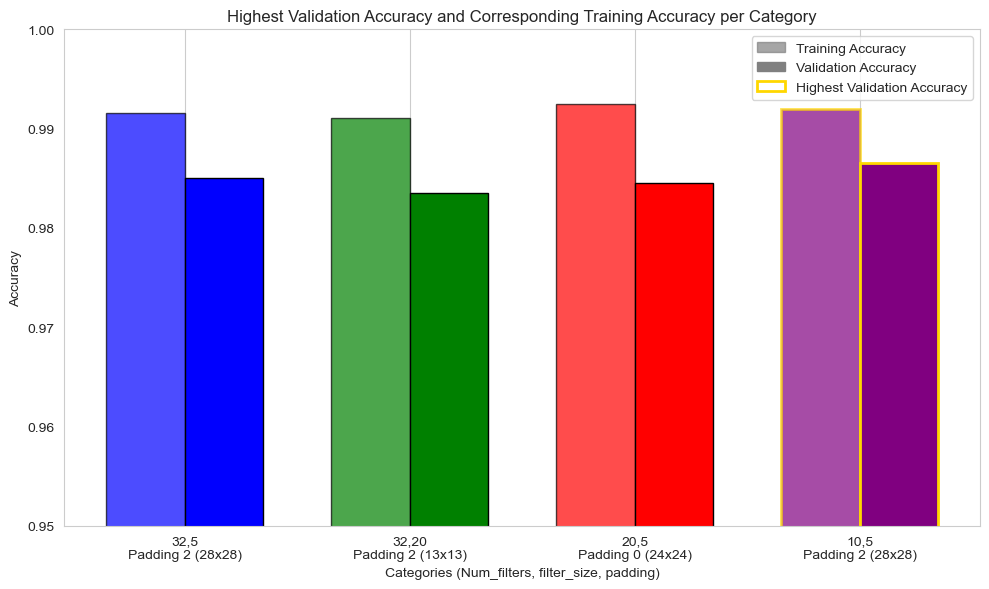

In [160]:
import matplotlib.pyplot as plt
import numpy as np

# Existing data (as you have provided)
data_no_conv = {
    'steps': [2500, 3000, 3500],
    'train_acc': [0.9793, 0.9781, 0.9827],
    'val_acc': [0.96, 0.9635, 0.9665]
}

data_conv_32_5 = {
    'Padding 0 (24x24)': {
        'steps': [500, 1000, 1500, 2000, 2500, 3000, 3500],
        'train_acc': [0.9174, 0.9765, 0.9793, 0.9875, 0.9917, 0.9905, 0.9946],
        'val_acc': [0.968, 0.9765, 0.981, 0.9805, 0.9805, 0.9835, 0.983]
    },
    'Padding 1 (26x26)': {
        'steps': [500, 1000, 1500, 2000, 2500, 3000, 3500],
        'train_acc': [0.9174, 0.9808, 0.98, 0.9893, 0.9930, 0.9919, 0.9948],
        'val_acc': [0.9705, 0.98, 0.982, 0.983, 0.9815, 0.9825, 0.983]
    },
    'Padding 2 (28x28)': {
        'steps': [500, 1000, 1500, 2000, 2500, 3000, 3500],
        'train_acc': [0.9152, 0.9788, 0.9819, 0.9883, 0.9926, 0.9916, 0.9955],
        'val_acc': [0.973, 0.971, 0.9815, 0.9765, 0.979, 0.985, 0.9805]
    }
}

# Data for other categories
data_conv_32_20 = {
    'Padding 0 (9x9)': {
        'steps': [500, 1000, 1500, 2000, 2500, 3000, 3500],
        'train_acc': [0.8933, 0.9665, 0.9714, 0.9786, 0.9871, 0.9834, 0.9875],
        'val_acc': [0.951, 0.9725, 0.9735, 0.9815, 0.9755, 0.9755, 0.973]
    },
    'Padding 1 (11x11)': {
        'steps': [500, 1000, 1500, 2000, 2500, 3000, 3500],
        'train_acc': [0.9008, 0.9702, 0.9728, 0.9811, 0.9860, 0.9853, 0.9890],
        'val_acc': [0.9575, 0.967, 0.971, 0.9735, 0.978, 0.9775, 0.978]
    },
    'Padding 2 (13x13)': {
        'steps': [500, 1000, 1500, 2000, 2500, 3000, 3500],
        'train_acc': [0.9064, 0.9722, 0.9756, 0.9829, 0.9875, 0.9874, 0.9911],
        'val_acc': [0.9565, 0.973, 0.973, 0.9765, 0.979, 0.982, 0.9835]
    }
}

data_conv_20_5 = {
    'Padding 0 (24x24)': {
        'steps': [500, 1000, 1500, 2000, 2500, 3000, 3500],
        'train_acc': [0.9211, 0.9821, 0.9826, 0.9887, 0.9931, 0.9925, 0.9959],
        'val_acc': [0.9685, 0.9795, 0.983, 0.9795, 0.979, 0.9845, 0.98]
    },
    'Padding 1 (26x26)': {
        'steps': [500, 1000, 1500, 2000, 2500, 3000, 3500],
        'train_acc': [0.9160, 0.9796, 0.9818, 0.9904, 0.9927, 0.9922, 0.9946],
        'val_acc': [0.964, 0.9735, 0.9765, 0.9765, 0.981, 0.9775, 0.976]
    },
    'Padding 2 (28x28)': {
        'steps': [500, 1000, 1500, 2000, 2500, 3000, 3500],
        'train_acc': [0.9118, 0.9795, 0.9816, 0.9877, 0.9923, 0.9909, 0.9962],
        'val_acc': [0.9685, 0.969, 0.976, 0.9815, 0.979, 0.983, 0.984]
    }
}

data_conv_10_5 = {
    'Padding 0 (24x24)': {
        'steps': [500, 1000, 1500, 2000, 2500, 3000, 3500],
        'train_acc': [0.8903, 0.9721, 0.9758, 0.9834, 0.9919, 0.9882, 0.9923],
        'val_acc': [0.9455, 0.965, 0.977, 0.9795, 0.9815, 0.9785, 0.9795]
    },
    'Padding 1 (26x26)': {
        'steps': [500, 1000, 1500, 2000, 2500, 3000, 3500],
        'train_acc': [0.9107, 0.9790, 0.9804, 0.9880, 0.9934, 0.9917, 0.9955],
        'val_acc': [0.9655, 0.9715, 0.973, 0.9745, 0.982, 0.977, 0.982]
    },
    'Padding 2 (28x28)': {
        'steps': [500, 1000, 1500, 2000, 2500, 3000, 3500],
        'train_acc': [0.9066, 0.9757, 0.9798, 0.9871, 0.9920, 0.9908, 0.9947],
        'val_acc': [0.9655, 0.9775, 0.982, 0.9795, 0.9865, 0.9775, 0.981]
    }
}

# Function to find the highest validation accuracy in a data dictionary
def find_highest_val_acc(data_dict, num_filters, filter_size):
    highest_val_acc = 0
    corresponding_train_acc = 0
    padding_used = ''
    for padding, data in data_dict.items():
        val_acc = data['val_acc']
        max_val = max(val_acc)
        idx = val_acc.index(max_val)
        train_acc = data['train_acc'][idx]
        if max_val > highest_val_acc:
            highest_val_acc = max_val
            corresponding_train_acc = train_acc
            padding_used = padding
    return {
        'category': f'Num_filters={num_filters}, filter_size={filter_size}',
        'num_filters': num_filters,
        'filter_size': filter_size,
        'padding': padding_used,
        'train_acc': corresponding_train_acc,
        'val_acc': highest_val_acc
    }

# List to store the results
categories = []

# Process each category
categories.append(find_highest_val_acc(data_conv_32_5, num_filters=32, filter_size=5))
categories.append(find_highest_val_acc(data_conv_32_20, num_filters=32, filter_size=20))
categories.append(find_highest_val_acc(data_conv_20_5, num_filters=20, filter_size=5))
categories.append(find_highest_val_acc(data_conv_10_5, num_filters=10, filter_size=5))

# Print the highest validation accuracies and corresponding training accuracies
print("Highest validation accuracy per category:")
for cat in categories:
    print(f"Category: {cat['category']}")
    print(f"  Highest validation accuracy: {cat['val_acc']}")
    print(f"  Corresponding training accuracy: {cat['train_acc']}")
    print(f"  Used padding: {cat['padding']}")
    print()

# Find the category with the highest validation accuracy among all
highest_overall = max(categories, key=lambda x: x['val_acc'])

print("The category with the highest validation accuracy overall:")
print(f"Category: {highest_overall['category']}")
print(f"  Highest validation accuracy: {highest_overall['val_acc']}")
print(f"  Corresponding training accuracy: {highest_overall['train_acc']}")
print(f"  Used padding: {highest_overall['padding']}")
print()

# Plot validation and training accuracies in the same color for each category
fig, ax = plt.subplots(figsize=(10,6))

index = np.arange(len(categories))
bar_width = 0.35

train_accuracies = [cat['train_acc'] for cat in categories]
val_accuracies = [cat['val_acc'] for cat in categories]
padding_used = [cat['padding'] for cat in categories]
category_labels = [f"{cat['num_filters']},{cat['filter_size']}\n{cat['padding']}" for cat in categories]

# Colors for each category
colors = ['blue', 'green', 'red', 'purple']

# Plot bars
for i in range(len(categories)):
    # Highlight the category with the highest validation accuracy
    if categories[i]['category'] == highest_overall['category']:
        edgecolor = 'gold'
        linewidth = 2
    else:
        edgecolor = 'black'
        linewidth = 1
    # Plot training accuracy
    ax.bar(index[i] - bar_width/2, train_accuracies[i], bar_width, color=colors[i], alpha=0.7, edgecolor=edgecolor, linewidth=linewidth)
    # Plot validation accuracy
    ax.bar(index[i] + bar_width/2, val_accuracies[i], bar_width, color=colors[i], alpha=1.0, edgecolor=edgecolor, linewidth=linewidth)

# Set labels and title
ax.set_xlabel('Categories (Num_filters, filter_size, padding)')
ax.set_ylabel('Accuracy')
ax.set_title('Highest Validation Accuracy and Corresponding Training Accuracy per Category')
ax.set_xticks(index)
ax.set_xticklabels(category_labels)

# Create custom legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='grey', edgecolor='grey', alpha=0.7, label='Training Accuracy'),
    Patch(facecolor='grey', edgecolor='grey', alpha=1.0, label='Validation Accuracy'),
    Patch(facecolor='none', edgecolor='gold', linewidth=2, label='Highest Validation Accuracy')
]
ax.legend(handles=legend_elements)

# Set y-axis limits for better visualization
ax.set_ylim([0.95, 1.0])

plt.grid(axis='y')
plt.tight_layout()
plt.show()


## Highest validation accuracy: 0.9865
## with num_filters = 10, filter_size = 5, padding = 2

## Plotting the results

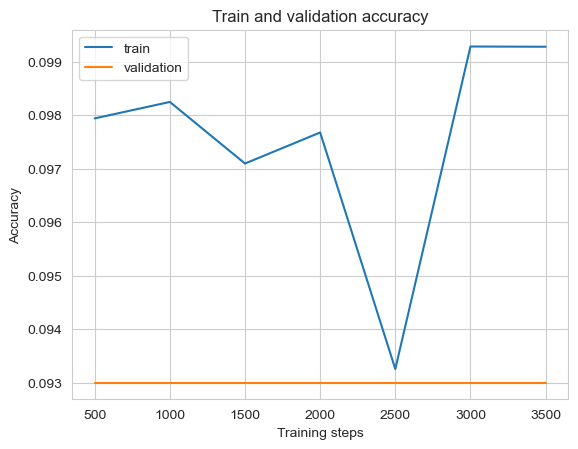

Validation accuracy: 0.093
Test accuracy: 0.100


In [129]:
steps = (np.arange(len(train_accuracies), dtype=int) + 1) * validation_every_steps

plt.figure()
plt.plot(steps, train_accuracies, label='train')
plt.plot(steps, valid_accuracies, label='validation')
plt.xlabel('Training steps')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Train and validation accuracy")
plt.show()

# Evaluate test set
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy_score(targets, predictions) * len(inputs))

    test_accuracy = np.sum(test_accuracies) / len(x_test)
    print(f"Validation accuracy: {valid_accuracies[-1]:.3f}")
    print(f"Test accuracy: {test_accuracy:.3f}")
    
    model.train()


# **Question: 2. Can the performance be increases even further by stacking more convolution layers?**

# The model

In [170]:
# Definer hyperparametre for hvert lag
num_filters_1 = 10
filter_size_1 = 5
padding_1 = 0  # Du kan overveje at ændre dette for at bevare dimensionerne

num_filters_2 = 20
filter_size_2 = 3
padding_2 = 0  # Juster padding for andet lag

channels = 1  # Inputkanaler
height = 28
width = 28
num_classes = 10  
stride = 1

# Beregn outputdimensioner efter første konvolutionslag
output_height_1 = (height - filter_size_1 + 2 * padding_1) // stride + 1
output_width_1 = (width - filter_size_1 + 2 * padding_1) // stride + 1

# Beregn outputdimensioner efter andet konvolutionslag
output_height_2 = (output_height_1 - filter_size_2 + 2 * padding_2) // stride + 1
output_width_2 = (output_width_1 - filter_size_2 + 2 * padding_2) // stride + 1

# Opdater n_features
n_features = num_filters_2 * output_height_2 * output_width_2

class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first forward pass."""
    def __init__(self):
        super(PrintSize, self).__init__()
        self.first = True
        
    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x

class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        activation_fn = nn.ReLU

        self.net = nn.Sequential(
            PrintSize(),
            nn.Conv2d(in_channels=channels, out_channels=num_filters_1, kernel_size=filter_size_1, padding=padding_1),
            activation_fn(),
            PrintSize(),
            nn.Conv2d(in_channels=num_filters_1, out_channels=num_filters_2, kernel_size=filter_size_2, padding=padding_2),
            activation_fn(),
            PrintSize(),
            nn.Flatten(),  # Konverterer (batch_size, channels, height, width) til (batch_size, channels * height * width)
            nn.Linear(n_features, 128),
            activation_fn(),
            nn.Linear(128, 128),
            activation_fn(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)

model = Model()
print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Model(
  (net): Sequential(
    (0): PrintSize()
    (1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (2): ReLU()
    (3): PrintSize()
    (4): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): PrintSize()
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=9680, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=128, bias=True)
    (11): ReLU()
    (12): Linear(in_features=128, out_features=10, bias=True)
  )
)


# The loop

In [171]:
batch_size = 64
num_epochs = 5
validation_every_steps = 500

train_set = TensorDataset(x_train, targets_train)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
valid_set = TensorDataset(x_valid, targets_valid)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, drop_last=False)
test_set = TensorDataset(x_test, targets_test)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=False)

step = 0
model.train()

train_accuracies = []
valid_accuracies = []
        
for epoch in range(num_epochs):
    
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        
        # Forward pass.
        output = model(inputs)
        
        # Compute loss.
        loss = loss_fn(output, targets)
        
        # Clean up gradients from the model.
        optimizer.zero_grad()
        
        # Compute gradients based on the loss from the current batch (backpropagation).
        loss.backward()
        
        # Take one optimizer step using the gradients computed in the previous step.
        optimizer.step()
        
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy_score(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in valid_loader:
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy_score(targets, predictions) * len(inputs))

                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(x_valid))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             validation accuracy: {valid_accuracies[-1]}")


print("Finished training.")

Size: torch.Size([64, 1, 28, 28])
Size: torch.Size([64, 10, 24, 24])
Size: torch.Size([64, 20, 22, 22])
Step 500     training accuracy: 0.91575
             validation accuracy: 0.9715
Step 1000    training accuracy: 0.9811643835616438
             validation accuracy: 0.975
Step 1500    training accuracy: 0.9815
             validation accuracy: 0.982
Step 2000    training accuracy: 0.9888698630136986
             validation accuracy: 0.984
Step 2500    training accuracy: 0.9928343949044586
             validation accuracy: 0.986
Step 3000    training accuracy: 0.99121875
             validation accuracy: 0.9845
Step 3500    training accuracy: 0.9947639627659575
             validation accuracy: 0.9805
Finished training.


# **Results of Q3)** 
# One more added convolution layer
## **Num_filters = 10, filter_size = 5, Padding=2**
## **Num_filters = 32, filter_size = 5, Padding=0**

1. Step 500     training accuracy: 0.9178125
             validation accuracy: 0.969
2. Step 1000    training accuracy: 0.9795947488584474
             validation accuracy: 0.973
3. Step 1500    training accuracy: 0.98175
             validation accuracy: 0.9785
4. Step 2000    training accuracy: 0.9890482305936074
             validation accuracy: 0.985
5. Step 2500    training accuracy: 0.9924363057324841
             validation accuracy: 0.983
6. Step 3000    training accuracy: 0.99234375
             validation accuracy: 0.9835
7. Step 3500    training accuracy: 0.9933095079787234
             validation accuracy: 0.9815

## **Num_filters = 10, filter_size = 5, Padding=2**
## **Num_filters = 20, filter_size = 5, Padding=0**


1. Step 500     training accuracy: 0.91953125
             validation accuracy: 0.972
2. Step 1000    training accuracy: 0.9810930365296804
             validation accuracy: 0.978
3. Step 1500    training accuracy: 0.98134375
             validation accuracy: 0.9785
4. Step 2000    training accuracy: 0.989083904109589
             validation accuracy: 0.981
5. Step 2500    training accuracy: 0.9925358280254777
             validation accuracy: 0.9855
6. Step 3000    training accuracy: 0.9906875
             validation accuracy: 0.983
7. Step 3500    training accuracy: 0.9936835106382979
             validation accuracy: 0.986

## **Num_filters = 10, filter_size = 5, Padding=2**
## **Num_filters = 20, filter_size = 3, Padding=0**

1. Step 500     training accuracy: 0.9054375
             validation accuracy: 0.9635
2. Step 1000    training accuracy: 0.9788812785388128
             validation accuracy: 0.979
3. Step 1500    training accuracy: 0.98103125
             validation accuracy: 0.978
4. Step 2000    training accuracy: 0.9858376141552512
             validation accuracy: 0.981
5. Step 2500    training accuracy: 0.9926353503184714
             validation accuracy: 0.9855
6. Step 3000    training accuracy: 0.9899375
             validation accuracy: 0.9805
7. Step 3500    training accuracy: 0.9932679521276596
             validation accuracy: 0.979

## **Num_filters = 10, filter_size = 5, Padding=0**
## **Num_filters = 20, filter_size = 3, Padding=0**

1. Step 500     training accuracy: 0.91575
             validation accuracy: 0.9715
2. Step 1000    training accuracy: 0.9811643835616438
             validation accuracy: 0.975
3. Step 1500    training accuracy: 0.9815
             validation accuracy: 0.982
4. Step 2000    training accuracy: 0.9888698630136986
             validation accuracy: 0.984
5. Step 2500    training accuracy: 0.9928343949044586
             validation accuracy: 0.986
6. Step 3000    training accuracy: 0.99121875
             validation accuracy: 0.9845
7. Step 3500    training accuracy: 0.9947639627659575
             validation accuracy: 0.9805


Highest validation accuracy per category:
Category 1:
  Conv Layer 1: Num_filters=10, filter_size=5, padding=2
  Conv Layer 2: Num_filters=32, filter_size=5, padding=0
  Highest validation accuracy: 0.985
  Corresponding training accuracy: 0.989

Category 2:
  Conv Layer 1: Num_filters=10, filter_size=5, padding=2
  Conv Layer 2: Num_filters=20, filter_size=5, padding=0
  Highest validation accuracy: 0.986
  Corresponding training accuracy: 0.9937

Category 3:
  Conv Layer 1: Num_filters=10, filter_size=5, padding=2
  Conv Layer 2: Num_filters=20, filter_size=3, padding=0
  Highest validation accuracy: 0.9855
  Corresponding training accuracy: 0.9926

Category 4:
  Conv Layer 1: Num_filters=10, filter_size=5, padding=0
  Conv Layer 2: Num_filters=20, filter_size=3, padding=0
  Highest validation accuracy: 0.986
  Corresponding training accuracy: 0.9928

The category with the highest validation accuracy overall:
  Conv Layer 1: Num_filters=10, filter_size=5, padding=2
  Conv Layer 2: Nu

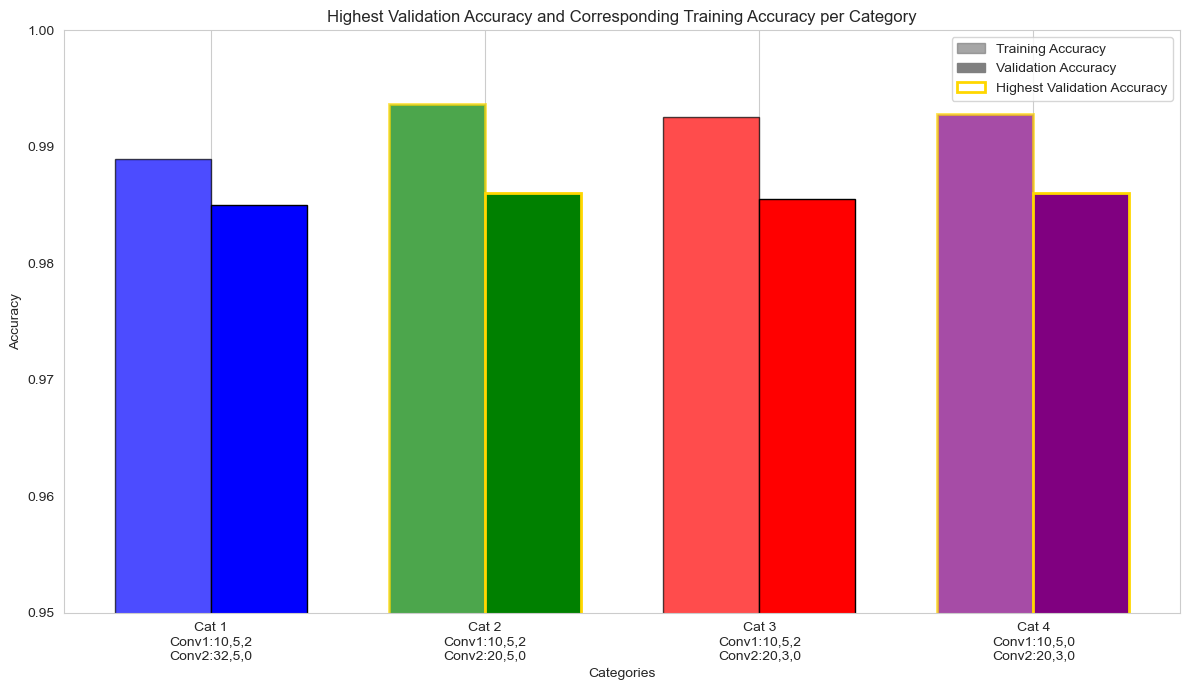

In [172]:
# Category 1
data_cat1 = {
    'steps': [500, 1000, 1500, 2000, 2500, 3000, 3500],
    'train_acc': [0.9178, 0.9796, 0.98175, 0.9890, 0.9924, 0.9923, 0.9933],
    'val_acc': [0.969, 0.973, 0.9785, 0.985, 0.983, 0.9835, 0.9815]
}

# Category 2
data_cat2 = {
    'steps': [500, 1000, 1500, 2000, 2500, 3000, 3500],
    'train_acc': [0.9195, 0.9811, 0.9813, 0.9891, 0.9925, 0.9907, 0.9937],
    'val_acc': [0.972, 0.978, 0.9785, 0.981, 0.9855, 0.983, 0.986]
}

# Category 3
data_cat3 = {
    'steps': [500, 1000, 1500, 2000, 2500, 3000, 3500],
    'train_acc': [0.9054, 0.9789, 0.9810, 0.9858, 0.9926, 0.9899, 0.9933],
    'val_acc': [0.9635, 0.979, 0.978, 0.981, 0.9855, 0.9805, 0.979]
}

# Category 4
data_cat4 = {
    'steps': [500, 1000, 1500, 2000, 2500, 3000, 3500],
    'train_acc': [0.91575, 0.9812, 0.9815, 0.9889, 0.9928, 0.9912, 0.9948],
    'val_acc': [0.9715, 0.975, 0.982, 0.984, 0.986, 0.9845, 0.9805]
}

def find_highest_val_acc_category(data_dict, category_info):
    val_acc = data_dict['val_acc']
    max_val = max(val_acc)
    idx = val_acc.index(max_val)
    train_acc = data_dict['train_acc'][idx]
    return {
        'category': category_info,
        'train_acc': train_acc,
        'val_acc': max_val
    }

# Prepare category information
categories = []

# Category 1
cat1_info = {
    'conv1': {'num_filters': 10, 'filter_size': 5, 'padding': 2},
    'conv2': {'num_filters': 32, 'filter_size': 5, 'padding': 0}
}
categories.append(find_highest_val_acc_category(data_cat1, cat1_info))

# Category 2
cat2_info = {
    'conv1': {'num_filters': 10, 'filter_size': 5, 'padding': 2},
    'conv2': {'num_filters': 20, 'filter_size': 5, 'padding': 0}
}
categories.append(find_highest_val_acc_category(data_cat2, cat2_info))

# Category 3
cat3_info = {
    'conv1': {'num_filters': 10, 'filter_size': 5, 'padding': 2},
    'conv2': {'num_filters': 20, 'filter_size': 3, 'padding': 0}
}
categories.append(find_highest_val_acc_category(data_cat3, cat3_info))

# Category 4
cat4_info = {
    'conv1': {'num_filters': 10, 'filter_size': 5, 'padding': 0},
    'conv2': {'num_filters': 20, 'filter_size': 3, 'padding': 0}
}
categories.append(find_highest_val_acc_category(data_cat4, cat4_info))

print("Highest validation accuracy per category:")
for i, cat in enumerate(categories, 1):
    conv1 = cat['category']['conv1']
    conv2 = cat['category']['conv2']
    print(f"Category {i}:")
    print(f"  Conv Layer 1: Num_filters={conv1['num_filters']}, filter_size={conv1['filter_size']}, padding={conv1['padding']}")
    print(f"  Conv Layer 2: Num_filters={conv2['num_filters']}, filter_size={conv2['filter_size']}, padding={conv2['padding']}")
    print(f"  Highest validation accuracy: {cat['val_acc']}")
    print(f"  Corresponding training accuracy: {cat['train_acc']}\n")



# Find the category with the highest validation accuracy
highest_overall = max(categories, key=lambda x: x['val_acc'])

print("The category with the highest validation accuracy overall:")
conv1 = highest_overall['category']['conv1']
conv2 = highest_overall['category']['conv2']
print(f"  Conv Layer 1: Num_filters={conv1['num_filters']}, filter_size={conv1['filter_size']}, padding={conv1['padding']}")
print(f"  Conv Layer 2: Num_filters={conv2['num_filters']}, filter_size={conv2['filter_size']}, padding={conv2['padding']}")
print(f"  Highest validation accuracy: {highest_overall['val_acc']}")
print(f"  Corresponding training accuracy: {highest_overall['train_acc']}\n")


import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Prepare data for plotting
index = np.arange(len(categories))
bar_width = 0.35

train_accuracies = [cat['train_acc'] for cat in categories]
val_accuracies = [cat['val_acc'] for cat in categories]
category_labels = [
    f"Cat {i+1}\nConv1:{cat['category']['conv1']['num_filters']},{cat['category']['conv1']['filter_size']},{cat['category']['conv1']['padding']}\n"
    f"Conv2:{cat['category']['conv2']['num_filters']},{cat['category']['conv2']['filter_size']},{cat['category']['conv2']['padding']}"
    for i, cat in enumerate(categories)
]

# Colors for each category
colors = ['blue', 'green', 'red', 'purple']

# Plot bars
fig, ax = plt.subplots(figsize=(12, 7))

for i in range(len(categories)):
    # Highlight the category with the highest validation accuracy
    if categories[i]['val_acc'] == highest_overall['val_acc']:
        edgecolor = 'gold'
        linewidth = 2
    else:
        edgecolor = 'black'
        linewidth = 1
    # Plot training accuracy
    ax.bar(index[i] - bar_width/2, train_accuracies[i], bar_width, color=colors[i], alpha=0.7,
           edgecolor=edgecolor, linewidth=linewidth)
    # Plot validation accuracy
    ax.bar(index[i] + bar_width/2, val_accuracies[i], bar_width, color=colors[i], alpha=1.0,
           edgecolor=edgecolor, linewidth=linewidth)

# Set labels and title
ax.set_xlabel('Categories')
ax.set_ylabel('Accuracy')
ax.set_title('Highest Validation Accuracy and Corresponding Training Accuracy per Category')
ax.set_xticks(index)
ax.set_xticklabels(category_labels)

# Create custom legend
legend_elements = [
    Patch(facecolor='grey', edgecolor='grey', alpha=0.7, label='Training Accuracy'),
    Patch(facecolor='grey', edgecolor='grey', alpha=1.0, label='Validation Accuracy'),
    Patch(facecolor='none', edgecolor='gold', linewidth=2, label='Highest Validation Accuracy')
]
ax.legend(handles=legend_elements)

# Set y-axis limits
ax.set_ylim([0.95, 1.0])

plt.grid(axis='y')
plt.tight_layout()
plt.show()







## I did not see any significant improvement in the performance by adding more convolution layers. The performance was already good with one convolution layer.


# **Question: 3.** 

We now have a deeper network than the initial simple feedforward network. What happens if we replace all convolutional layers with linear layers? Is this deep feedforward network performing as well as the convolutional one?

# The model with linear layers

In [183]:
# Define hyperparameters
channels = 1  # Input channels
height = 28
width = 28
num_classes = 10
input_size = channels * height * width  # 784

# Sizes of the linear layers
hidden_size_1 = 256
hidden_size_2 = 512

class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first forward pass."""
    def __init__(self):
        super(PrintSize, self).__init__()
        self.first = True
        
    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x

class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        activation_fn = nn.ReLU

        self.net = nn.Sequential(
            PrintSize(),
            nn.Flatten(),  # Flatten the input images
            activation_fn(),
            PrintSize(),
            nn.Linear(input_size, hidden_size_1),
            activation_fn(),
            PrintSize(),
            nn.Linear(hidden_size_1, hidden_size_2),
            activation_fn(),
            PrintSize(),
            nn.Linear(hidden_size_2, 128),
            activation_fn(),
            nn.Linear(128, 128),
            activation_fn(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)

model = Model()
print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


Model(
  (net): Sequential(
    (0): PrintSize()
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): ReLU()
    (3): PrintSize()
    (4): Linear(in_features=784, out_features=256, bias=True)
    (5): ReLU()
    (6): PrintSize()
    (7): Linear(in_features=256, out_features=512, bias=True)
    (8): ReLU()
    (9): PrintSize()
    (10): Linear(in_features=512, out_features=128, bias=True)
    (11): ReLU()
    (12): Linear(in_features=128, out_features=128, bias=True)
    (13): ReLU()
    (14): Linear(in_features=128, out_features=10, bias=True)
  )
)


# The Loop

In [184]:
batch_size = 64
num_epochs = 5
validation_every_steps = 500

train_set = TensorDataset(x_train, targets_train)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
valid_set = TensorDataset(x_valid, targets_valid)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, drop_last=False)
test_set = TensorDataset(x_test, targets_test)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=False)

step = 0
model.train()

train_accuracies = []
valid_accuracies = []
        
for epoch in range(num_epochs):
    
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        
        # Forward pass.
        output = model(inputs)
        
        # Compute loss.
        loss = loss_fn(output, targets)
        
        # Clean up gradients from the model.
        optimizer.zero_grad()
        
        # Compute gradients based on the loss from the current batch (backpropagation).
        loss.backward()
        
        # Take one optimizer step using the gradients computed in the previous step.
        optimizer.step()
        
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy_score(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in valid_loader:
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy_score(targets, predictions) * len(inputs))

                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(x_valid))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             validation accuracy: {valid_accuracies[-1]}")


print("Finished training.")

Size: torch.Size([64, 1, 28, 28])
Size: torch.Size([64, 784])
Size: torch.Size([64, 256])
Size: torch.Size([64, 512])
Step 500     training accuracy: 0.87228125
             validation accuracy: 0.936
Step 1000    training accuracy: 0.9628995433789954
             validation accuracy: 0.95
Step 1500    training accuracy: 0.96428125
             validation accuracy: 0.9595
Step 2000    training accuracy: 0.974957191780822
             validation accuracy: 0.9695
Step 2500    training accuracy: 0.9811902866242038
             validation accuracy: 0.9695
Step 3000    training accuracy: 0.98078125
             validation accuracy: 0.9695
Step 3500    training accuracy: 0.9852061170212766
             validation accuracy: 0.971
Finished training.


# **Results of Q3)** 
# Replace all convolutional layers with linear layers:

# hidden_size = 256 (1 hidden layer) hidden_size = 128 (2 hidden layers)

1. Step 500     training accuracy: 0.851625
             validation accuracy: 0.931
2. Step 1000    training accuracy: 0.9548373287671232
             validation accuracy: 0.961
3. Step 1500    training accuracy: 0.95934375
             validation accuracy: 0.9585
4. Step 2000    training accuracy: 0.9726740867579908
             validation accuracy: 0.963
5. Step 2500    training accuracy: 0.9792993630573248
             validation accuracy: 0.972
6. Step 3000    training accuracy: 0.98090625
             validation accuracy: 0.966
7. Step 3500    training accuracy: 0.987076130319149
             validation accuracy: 0.9715
            

# hidden_size = 512 (1 hidden layer) hidden_size = 256 (2 hidden layers)
1. Step 500     training accuracy: 0.87690625
             validation accuracy: 0.953
2. Step 1000    training accuracy: 0.9623287671232876
             validation accuracy: 0.9635
3. Step 1500    training accuracy: 0.9668125
             validation accuracy: 0.9695
4. Step 2000    training accuracy: 0.9756706621004566
             validation accuracy: 0.9695
5. Step 2500    training accuracy: 0.9834792993630573
             validation accuracy: 0.9735
6. Step 3000    training accuracy: 0.98128125
             validation accuracy: 0.9625
7. Step 3500    training accuracy: 0.9857463430851063
             validation accuracy: 0.9775


# hidden_size = 1024 (1 hidden layer) hidden_size = 512 (2 hidden layers)
1. Step 500     training accuracy: 0.8939375
             validation accuracy: 0.9335
2. Step 1000    training accuracy: 0.9672517123287672
             validation accuracy: 0.9655
3. Step 1500    training accuracy: 0.96859375
             validation accuracy: 0.9685
4. Step 2000    training accuracy: 0.9787742579908676
             validation accuracy: 0.9685
5. Step 2500    training accuracy: 0.98546974522293
             validation accuracy: 0.974
6. Step 3000    training accuracy: 0.9835625
             validation accuracy: 0.977
7. Step 3500    training accuracy: 0.9872007978723404
             validation accuracy: 0.973

# hidden_size = 512 (1 hidden layer) hidden_size = 1024 (2 hidden layers)
1. Step 500     training accuracy: 0.885625
             validation accuracy: 0.951
2. Step 1000    training accuracy: 0.9631849315068494
             validation accuracy: 0.966
3. Step 1500    training accuracy: 0.96971875
             validation accuracy: 0.9665
4. Step 2000    training accuracy: 0.977918093607306
             validation accuracy: 0.9685
5. Step 2500    training accuracy: 0.9838773885350318
             validation accuracy: 0.973
6. Step 3000    training accuracy: 0.98275
             validation accuracy: 0.969
7. Step 3500    training accuracy: 0.9856632313829787
             validation accuracy: 0.972
# hidden_size = 256 (1 hidden layer) hidden_size = 512 (2 hidden layers)

1. Step 500     training accuracy: 0.87228125
             validation accuracy: 0.936
2. Step 1000    training accuracy: 0.9628995433789954
             validation accuracy: 0.95
3. Step 1500    training accuracy: 0.96428125
             validation accuracy: 0.9595
4. Step 2000    training accuracy: 0.974957191780822
             validation accuracy: 0.9695
5. Step 2500    training accuracy: 0.9811902866242038
             validation accuracy: 0.9695
6. Step 3000    training accuracy: 0.98078125
             validation accuracy: 0.9695
7. Step 3500    training accuracy: 0.9852061170212766
             validation accuracy: 0.971

Highest validation accuracy per category:
Category 1:
  Hidden Layers: 1x256 or 2x128
  Highest validation accuracy: 0.972
  Corresponding training accuracy: 0.9792993630573248

Category 2:
  Hidden Layers: 1x512 or 2x256
  Highest validation accuracy: 0.9775
  Corresponding training accuracy: 0.9857463430851063

Category 3:
  Hidden Layers: 1x1024 or 2x512
  Highest validation accuracy: 0.977
  Corresponding training accuracy: 0.9835625

Category 4:
  Hidden Layers: 1x512 or 2x1024
  Highest validation accuracy: 0.973
  Corresponding training accuracy: 0.9838773885350318

Category 5:
  Hidden Layers: 1x256 or 2x512
  Highest validation accuracy: 0.971
  Corresponding training accuracy: 0.9852061170212766

The category with the highest validation accuracy overall:
  Hidden Layers: 1x512 or 2x256
  Highest validation accuracy: 0.9775
  Corresponding training accuracy: 0.9857463430851063



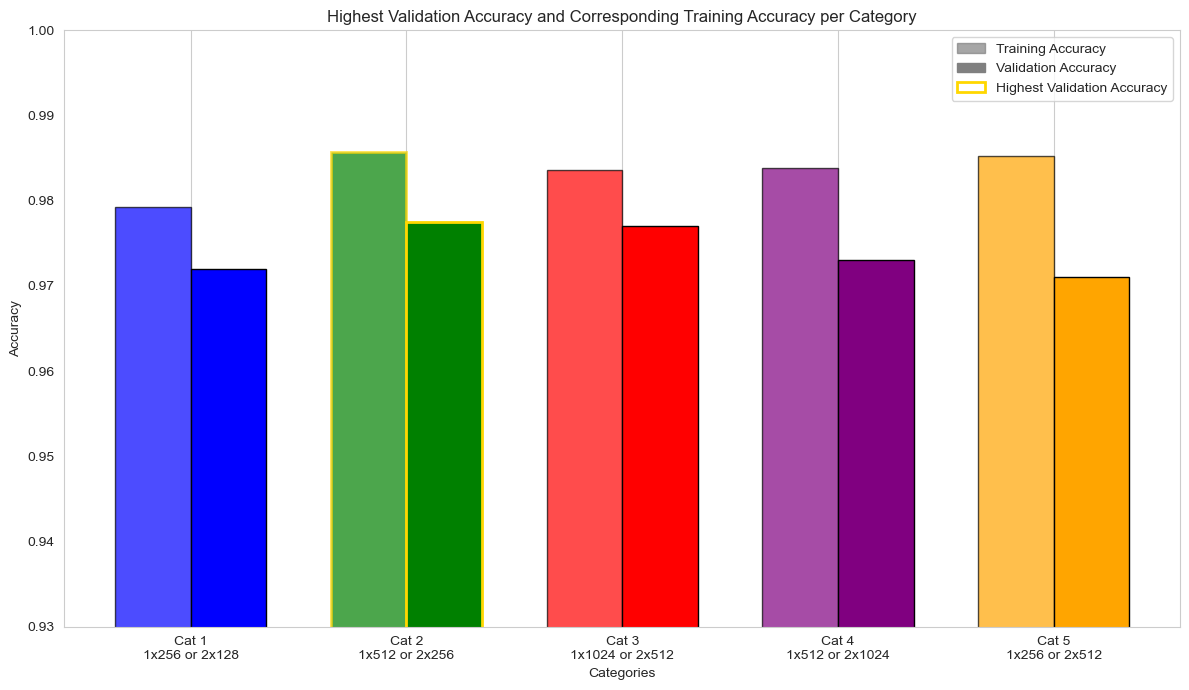

In [185]:
# Category 1
data_cat1 = {
    'steps': [500, 1000, 1500, 2000, 2500, 3000, 3500],
    'train_acc': [0.851625, 0.9548373287671232, 0.95934375, 0.9726740867579908, 0.9792993630573248, 0.98090625, 0.987076130319149],
    'val_acc': [0.931, 0.961, 0.9585, 0.963, 0.972, 0.966, 0.9715],
    'hidden_layers': '1x256 or 2x128'
}

# Category 2
data_cat2 = {
    'steps': [500, 1000, 1500, 2000, 2500, 3000, 3500],
    'train_acc': [0.87690625, 0.9623287671232876, 0.9668125, 0.9756706621004566, 0.9834792993630573, 0.98128125, 0.9857463430851063],
    'val_acc': [0.953, 0.9635, 0.9695, 0.9695, 0.9735, 0.9625, 0.9775],
    'hidden_layers': '1x512 or 2x256'
}

# Category 3
data_cat3 = {
    'steps': [500, 1000, 1500, 2000, 2500, 3000, 3500],
    'train_acc': [0.8939375, 0.9672517123287672, 0.96859375, 0.9787742579908676, 0.98546974522293, 0.9835625, 0.9872007978723404],
    'val_acc': [0.9335, 0.9655, 0.9685, 0.9685, 0.974, 0.977, 0.973],
    'hidden_layers': '1x1024 or 2x512'
}

# Category 4
data_cat4 = {
    'steps': [500, 1000, 1500, 2000, 2500, 3000, 3500],
    'train_acc': [0.885625, 0.9631849315068494, 0.96971875, 0.977918093607306, 0.9838773885350318, 0.98275, 0.9856632313829787],
    'val_acc': [0.951, 0.966, 0.9665, 0.9685, 0.973, 0.969, 0.972],
    'hidden_layers': '1x512 or 2x1024'
}

# Category 5
data_cat5 = {
    'steps': [500, 1000, 1500, 2000, 2500, 3000, 3500],
    'train_acc': [0.87228125, 0.9628995433789954, 0.96428125, 0.974957191780822, 0.9811902866242038, 0.98078125, 0.9852061170212766],
    'val_acc': [0.936, 0.95, 0.9595, 0.9695, 0.9695, 0.9695, 0.971],
    'hidden_layers': '1x256 or 2x512'
}


def find_highest_val_acc_category(data_dict, category_info):
    val_acc = data_dict['val_acc']
    max_val = max(val_acc)
    idx = val_acc.index(max_val)
    train_acc = data_dict['train_acc'][idx]
    return {
        'category': category_info,
        'train_acc': train_acc,
        'val_acc': max_val
    }



# Prepare category information
categories = []

# Category 1
cat1_info = {
    'hidden_layers': data_cat1['hidden_layers']
}
categories.append(find_highest_val_acc_category(data_cat1, cat1_info))

# Category 2
cat2_info = {
    'hidden_layers': data_cat2['hidden_layers']
}
categories.append(find_highest_val_acc_category(data_cat2, cat2_info))

# Category 3
cat3_info = {
    'hidden_layers': data_cat3['hidden_layers']
}
categories.append(find_highest_val_acc_category(data_cat3, cat3_info))

# Category 4
cat4_info = {
    'hidden_layers': data_cat4['hidden_layers']
}
categories.append(find_highest_val_acc_category(data_cat4, cat4_info))

# Category 5
cat5_info = {
    'hidden_layers': data_cat5['hidden_layers']
}
categories.append(find_highest_val_acc_category(data_cat5, cat5_info))


print("Highest validation accuracy per category:")
for i, cat in enumerate(categories, 1):
    hidden_layers = cat['category']['hidden_layers']
    print(f"Category {i}:")
    print(f"  Hidden Layers: {hidden_layers}")
    print(f"  Highest validation accuracy: {cat['val_acc']}")
    print(f"  Corresponding training accuracy: {cat['train_acc']}\n")



# Find the category with the highest validation accuracy
highest_overall = max(categories, key=lambda x: x['val_acc'])

print("The category with the highest validation accuracy overall:")
hidden_layers = highest_overall['category']['hidden_layers']
print(f"  Hidden Layers: {hidden_layers}")
print(f"  Highest validation accuracy: {highest_overall['val_acc']}")
print(f"  Corresponding training accuracy: {highest_overall['train_acc']}\n")



import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Prepare data for plotting
index = np.arange(len(categories))
bar_width = 0.35

train_accuracies = [cat['train_acc'] for cat in categories]
val_accuracies = [cat['val_acc'] for cat in categories]
category_labels = [
    f"Cat {i+1}\n{cat['category']['hidden_layers']}"
    for i, cat in enumerate(categories)
]

# Colors for each category
colors = ['blue', 'green', 'red', 'purple', 'orange']

# Plot bars
fig, ax = plt.subplots(figsize=(12, 7))

for i in range(len(categories)):
    # Highlight the category with the highest validation accuracy
    if categories[i]['val_acc'] == highest_overall['val_acc']:
        edgecolor = 'gold'
        linewidth = 2
    else:
        edgecolor = 'black'
        linewidth = 1
    # Plot training accuracy
    ax.bar(index[i] - bar_width/2, train_accuracies[i], bar_width, color=colors[i], alpha=0.7,
           edgecolor=edgecolor, linewidth=linewidth)
    # Plot validation accuracy
    ax.bar(index[i] + bar_width/2, val_accuracies[i], bar_width, color=colors[i], alpha=1.0,
           edgecolor=edgecolor, linewidth=linewidth)

# Set labels and title
ax.set_xlabel('Categories')
ax.set_ylabel('Accuracy')
ax.set_title('Highest Validation Accuracy and Corresponding Training Accuracy per Category')
ax.set_xticks(index)
ax.set_xticklabels(category_labels)

# Create custom legend
legend_elements = [
    Patch(facecolor='grey', edgecolor='grey', alpha=0.7, label='Training Accuracy'),
    Patch(facecolor='grey', edgecolor='grey', alpha=1.0, label='Validation Accuracy'),
    Patch(facecolor='none', edgecolor='gold', linewidth=2, label='Highest Validation Accuracy')
]
ax.legend(handles=legend_elements)

# Set y-axis limits
ax.set_ylim([0.93, 1.0])

plt.grid(axis='y')
plt.tight_layout()
plt.show()



# **Question: 4. - Max pooling**
Max-pooling is a technique for decreasing the spatial resolution of an image while retaining the important features. Effectively this gives a local translational invariance and reduces the computation by a factor of four. In the classification algorithm which is usually desirable. You can either:

add a maxpool layer (see the PyTorch docs, and try with kernel_size=2 and stride=2) after the convolution layer,


# The model with 4 convolution layer with maxpooling

In [194]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define hyperparameters for the convolutional layers
num_filters1 = 16
num_filters2 = 32
num_filters3 = 64
num_filters4 = 128

filter_size = 3
padding = 1  # To preserve spatial dimensions
stride_conv = 1  # Stride for convolutional layers
stride_pool = 2  # Stride for max-pooling layers
pool_kernel_size = 2  # Kernel size for max-pooling

channels = 1  # Input channels (e.g., grayscale images)
height = 28
width = 28
num_classes = 10

# Function to calculate output dimensions after Conv or Pool layers
def calculate_output_size(input_size, kernel_size, padding, stride):
    return (input_size - kernel_size + 2 * padding) // stride + 1

# Calculate output dimensions after each Conv + Pool layer
# After Conv Layer 1
output_height1 = calculate_output_size(height, filter_size, padding, stride_conv)
output_width1 = calculate_output_size(width, filter_size, padding, stride_conv)

# After MaxPool Layer 1
output_height1_pool = output_height1 // stride_pool
output_width1_pool = output_width1 // stride_pool

# After Conv Layer 2
output_height2 = calculate_output_size(output_height1_pool, filter_size, padding, stride_conv)
output_width2 = calculate_output_size(output_width1_pool, filter_size, padding, stride_conv)

# After MaxPool Layer 2
output_height2_pool = output_height2 // stride_pool
output_width2_pool = output_width2 // stride_pool

# After Conv Layer 3
output_height3 = calculate_output_size(output_height2_pool, filter_size, padding, stride_conv)
output_width3 = calculate_output_size(output_width2_pool, filter_size, padding, stride_conv)

# After MaxPool Layer 3
output_height3_pool = output_height3 // stride_pool
output_width3_pool = output_width3 // stride_pool

# After Conv Layer 4
output_height4 = calculate_output_size(output_height3_pool, filter_size, padding, stride_conv)
output_width4 = calculate_output_size(output_width3_pool, filter_size, padding, stride_conv)

# After MaxPool Layer 4
output_height4_pool = output_height4 // stride_pool
output_width4_pool = output_width4 // stride_pool

# Update n_features based on the final output dimensions
n_features = num_filters4 * output_height4_pool * output_width4_pool

print(f"Final feature map size: {num_filters4} channels, {output_height4_pool}x{output_width4_pool}")
print(f"n_features: {n_features}")

class PrintSize(nn.Module):
    """Utility module to print the current shape of a Tensor in Sequential, only on the first forward pass."""
    def __init__(self):
        super(PrintSize, self).__init__()
        self.first = True
        
    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        activation_fn = nn.ReLU

        self.net = nn.Sequential(
            PrintSize(),
            nn.Conv2d(in_channels=channels, out_channels=num_filters1, kernel_size=filter_size, padding=padding, stride=stride_conv),  # Conv Layer 1
            activation_fn(),
            nn.MaxPool2d(kernel_size=pool_kernel_size, stride=stride_pool),
            PrintSize(),
            
            nn.Conv2d(in_channels=num_filters1, out_channels=num_filters2, kernel_size=filter_size, padding=padding, stride=stride_conv),  # Conv Layer 2
            activation_fn(),
            nn.MaxPool2d(kernel_size=pool_kernel_size, stride=stride_pool),
            PrintSize(),
            
            nn.Conv2d(in_channels=num_filters2, out_channels=num_filters3, kernel_size=filter_size, padding=padding, stride=stride_conv),  # Conv Layer 3
            activation_fn(),
            nn.MaxPool2d(kernel_size=pool_kernel_size, stride=stride_pool),
            PrintSize(),
            
            nn.Conv2d(in_channels=num_filters3, out_channels=num_filters4, kernel_size=filter_size, padding=padding, stride=stride_conv),  # Conv Layer 4
            activation_fn(),
            nn.MaxPool2d(kernel_size=pool_kernel_size, stride=stride_pool),
            PrintSize(),
            
            nn.Flatten(),  # Converts (batch_size, channels, height, width) to (batch_size, channels * height * width)
            nn.Linear(n_features, 128),
            activation_fn(),
            nn.Linear(128, 128),
            activation_fn(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# Instantiate the model
model = Model()
print(model)

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)



Final feature map size: 128 channels, 1x1
n_features: 128
Model(
  (net): Sequential(
    (0): PrintSize()
    (1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): PrintSize()
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): PrintSize()
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): PrintSize()
    (13): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU()
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): PrintSize()
    (17): Flatten(start_dim=1, end_dim=-1)
    (18): Linear(in_features=128, out_features=128, bias=Tr

# The loop


In [195]:
batch_size = 64
num_epochs = 5
validation_every_steps = 500

train_set = TensorDataset(x_train, targets_train)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
valid_set = TensorDataset(x_valid, targets_valid)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, drop_last=False)
test_set = TensorDataset(x_test, targets_test)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=False)

step = 0
model.train()

train_accuracies = []
valid_accuracies = []
        
for epoch in range(num_epochs):
    
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        
        # Forward pass.
        output = model(inputs)
        
        # Compute loss.
        loss = loss_fn(output, targets)
        
        # Clean up gradients from the model.
        optimizer.zero_grad()
        
        # Compute gradients based on the loss from the current batch (backpropagation).
        loss.backward()
        
        # Take one optimizer step using the gradients computed in the previous step.
        optimizer.step()
        
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy_score(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in valid_loader:
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy_score(targets, predictions) * len(inputs))

                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(x_valid))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             validation accuracy: {valid_accuracies[-1]}")


print("Finished training.")

Size: torch.Size([64, 1, 28, 28])
Size: torch.Size([64, 16, 14, 14])
Size: torch.Size([64, 32, 7, 7])
Size: torch.Size([64, 64, 3, 3])
Size: torch.Size([64, 128, 1, 1])
Step 500     training accuracy: 0.8431875
             validation accuracy: 0.9715
Step 1000    training accuracy: 0.9732448630136986
             validation accuracy: 0.974
Step 1500    training accuracy: 0.97478125
             validation accuracy: 0.978
Step 2000    training accuracy: 0.9827340182648402
             validation accuracy: 0.977
Step 2500    training accuracy: 0.9880573248407644
             validation accuracy: 0.983
Step 3000    training accuracy: 0.9860625
             validation accuracy: 0.982
Step 3500    training accuracy: 0.9895694813829787
             validation accuracy: 0.981
Finished training.


# **The model** 
# One convolution layer with stride=2 in the convolution layer

In [196]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define hyperparameters for the convolutional layers
num_filters1 = 16
num_filters2 = 32
num_filters3 = 64
num_filters4 = 128

filter_size = 3
padding = 1  # To preserve spatial dimensions
stride_conv = 2  # Stride for convolutional layers (downsampling)


channels = 1  # Input channels (e.g., grayscale images)
height = 28
width = 28
num_classes = 10

# Function to calculate output dimensions after Conv layers
def calculate_output_size(input_size, kernel_size, padding, stride):
    return (input_size - kernel_size + 2 * padding) // stride + 1

# Calculate output dimensions after each Conv layer
# After Conv Layer 1
output_height1 = calculate_output_size(height, filter_size, padding, stride_conv)
output_width1 = calculate_output_size(width, filter_size, padding, stride_conv)

# After Conv Layer 2
output_height2 = calculate_output_size(output_height1, filter_size, padding, stride_conv)
output_width2 = calculate_output_size(output_width1, filter_size, padding, stride_conv)

# After Conv Layer 3
output_height3 = calculate_output_size(output_height2, filter_size, padding, stride_conv)
output_width3 = calculate_output_size(output_width2, filter_size, padding, stride_conv)

# After Conv Layer 4
output_height4 = calculate_output_size(output_height3, filter_size, padding, stride_conv)
output_width4 = calculate_output_size(output_width3, filter_size, padding, stride_conv)

# Update n_features based on the final output dimensions
n_features = num_filters4 * output_height4 * output_width4

print(f"Final feature map size: {num_filters4} channels, {output_height4}x{output_width4}")
print(f"n_features: {n_features}")

class PrintSize(nn.Module):
    """Utility module to print the current shape of a Tensor in Sequential, only on the first forward pass."""
    def __init__(self):
        super(PrintSize, self).__init__()
        self.first = True
        
    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x

class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        activation_fn = nn.ReLU

        self.net = nn.Sequential(
 PrintSize(),
            nn.Conv2d(in_channels=channels, out_channels=num_filters1, kernel_size=filter_size, padding=padding, stride=stride_conv),  # Conv Layer 1
            activation_fn(),
            PrintSize(),
            
            nn.Conv2d(in_channels=num_filters1, out_channels=num_filters2, kernel_size=filter_size, padding=padding, stride=stride_conv),  # Conv Layer 2
            activation_fn(),
            PrintSize(),
            
            nn.Conv2d(in_channels=num_filters2, out_channels=num_filters3, kernel_size=filter_size, padding=padding, stride=stride_conv),  # Conv Layer 3
            activation_fn(),
            PrintSize(),
            
            nn.Conv2d(in_channels=num_filters3, out_channels=num_filters4, kernel_size=filter_size, padding=padding, stride=stride_conv),  # Conv Layer 4
            activation_fn(),
            PrintSize(),


            nn.Flatten(),  # Converts (batch_size, channels, height, width) to (batch_size, channels * height * width)
            nn.Linear(n_features, 128),
            activation_fn(),
            nn.Linear(128, 128),
            activation_fn(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# Instantiate the model
model = Model()
print(model)

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


Final feature map size: 128 channels, 2x2
n_features: 512
Model(
  (net): Sequential(
    (0): PrintSize()
    (1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (2): ReLU()
    (3): PrintSize()
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): PrintSize()
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): ReLU()
    (9): PrintSize()
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (11): ReLU()
    (12): PrintSize()
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=512, out_features=128, bias=True)
    (15): ReLU()
    (16): Linear(in_features=128, out_features=128, bias=True)
    (17): ReLU()
    (18): Linear(in_features=128, out_features=10, bias=True)
  )
)


# The loop

In [197]:
batch_size = 64
num_epochs = 5
validation_every_steps = 500

train_set = TensorDataset(x_train, targets_train)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
valid_set = TensorDataset(x_valid, targets_valid)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, drop_last=False)
test_set = TensorDataset(x_test, targets_test)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=False)

step = 0
model.train()

train_accuracies = []
valid_accuracies = []
        
for epoch in range(num_epochs):
    
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        
        # Forward pass.
        output = model(inputs)
        
        # Compute loss.
        loss = loss_fn(output, targets)
        
        # Clean up gradients from the model.
        optimizer.zero_grad()
        
        # Compute gradients based on the loss from the current batch (backpropagation).
        loss.backward()
        
        # Take one optimizer step using the gradients computed in the previous step.
        optimizer.step()
        
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy_score(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in valid_loader:
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy_score(targets, predictions) * len(inputs))

                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(x_valid))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             validation accuracy: {valid_accuracies[-1]}")


print("Finished training.")

Size: torch.Size([64, 1, 28, 28])
Size: torch.Size([64, 16, 14, 14])
Size: torch.Size([64, 32, 7, 7])
Size: torch.Size([64, 64, 4, 4])
Size: torch.Size([64, 128, 2, 2])
Step 500     training accuracy: 0.83584375
             validation accuracy: 0.9535
Step 1000    training accuracy: 0.967537100456621
             validation accuracy: 0.968
Step 1500    training accuracy: 0.9711875
             validation accuracy: 0.9745
Step 2000    training accuracy: 0.9792023401826484
             validation accuracy: 0.981
Step 2500    training accuracy: 0.9864649681528662
             validation accuracy: 0.978
Step 3000    training accuracy: 0.9830625
             validation accuracy: 0.985
Step 3500    training accuracy: 0.9878241356382979
             validation accuracy: 0.986
Finished training.


# **Results of Q4)**

# One convolution layer with maxpooling

1. Size: torch.Size([64, 1, 28, 28])
2. Size: torch.Size([64, 16, 14, 14])
3. Size: torch.Size([64, 32, 7, 7])
4. Size: torch.Size([64, 64, 3, 3])
5. Size: torch.Size([64, 128, 1, 1])
1. Step 500     training accuracy: 0.8431875
             validation accuracy: 0.9715
2. Step 1000    training accuracy: 0.9732448630136986
             validation accuracy: 0.974
3. Step 1500    training accuracy: 0.97478125
             validation accuracy: 0.978
4. Step 2000    training accuracy: 0.9827340182648402
             validation accuracy: 0.977
5. Step 2500    training accuracy: 0.9880573248407644
             validation accuracy: 0.983
6. Step 3000    training accuracy: 0.9860625
             validation accuracy: 0.982
7. Step 3500    training accuracy: 0.9895694813829787
             validation accuracy: 0.981

# One convolution layer with stride=2 in the convolution layer


1. Size: torch.Size([64, 1, 28, 28])
2. Size: torch.Size([64, 16, 14, 14])
3. Size: torch.Size([64, 32, 7, 7])
4. Size: torch.Size([64, 64, 4, 4])
5. Size: torch.Size([64, 128, 2, 2])

1. Step 500     training accuracy: 0.83584375
             validation accuracy: 0.9535
2. Step 1000    training accuracy: 0.967537100456621
             validation accuracy: 0.968
3. Step 1500    training accuracy: 0.9711875
             validation accuracy: 0.9745
4. Step 2000    training accuracy: 0.9792023401826484
             validation accuracy: 0.981
5. Step 2500    training accuracy: 0.9864649681528662
             validation accuracy: 0.978
6. Step 3000    training accuracy: 0.9830625
             validation accuracy: 0.985
7. Step 3500    training accuracy: 0.9878241356382979
             validation accuracy: 0.986


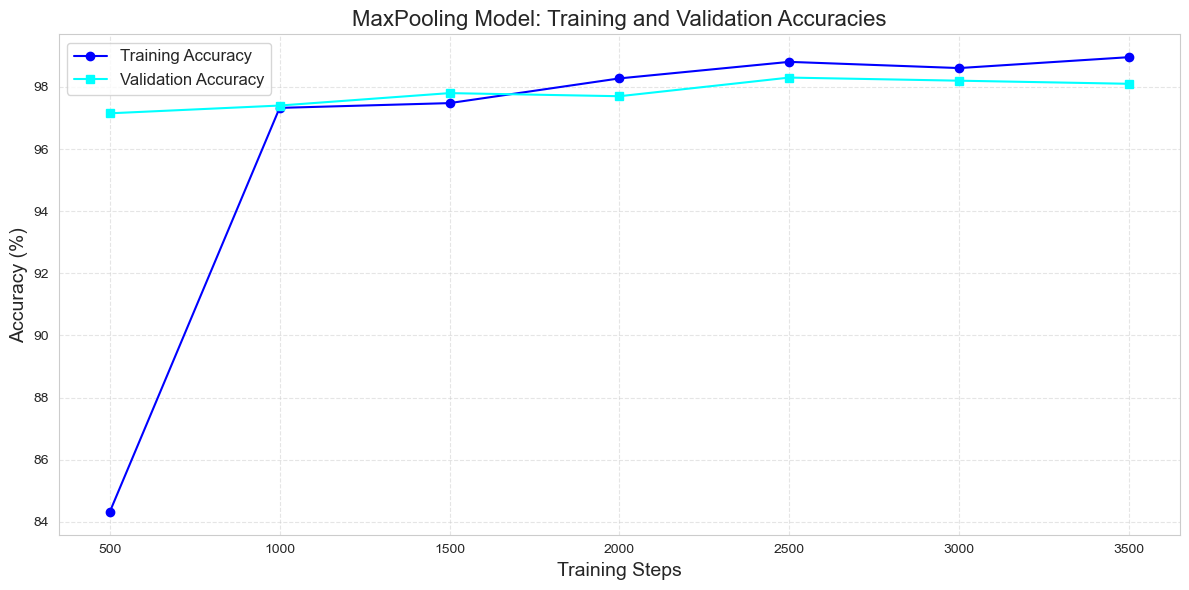

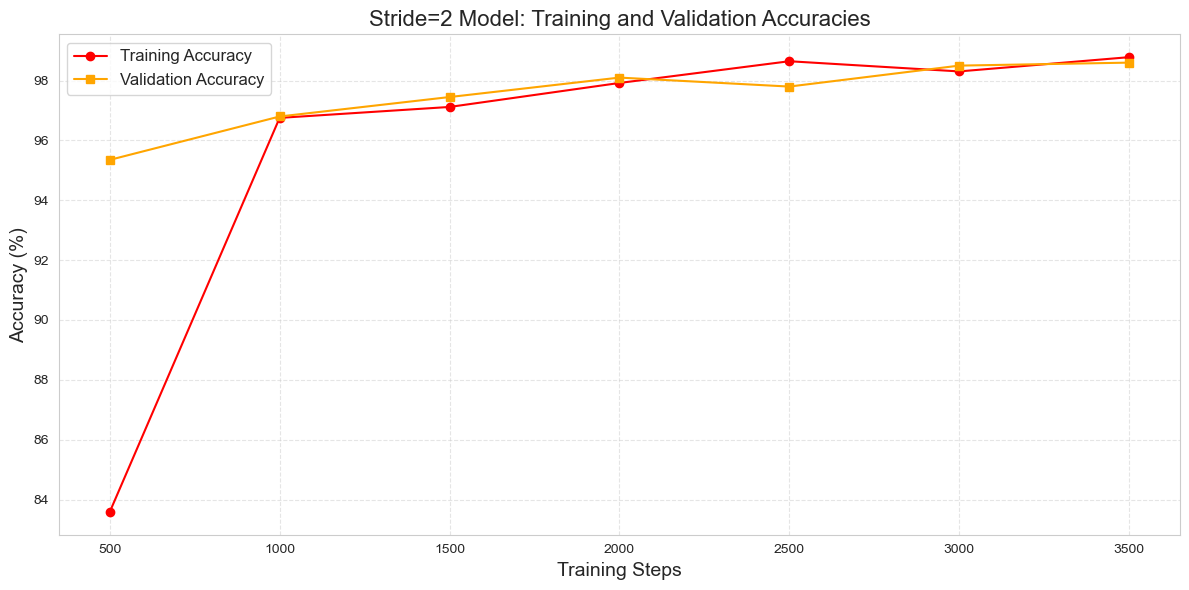

MaxPooling Model: Best Validation Accuracy = 98.30% at Step 2500
Stride=2 Model: Best Validation Accuracy = 98.60% at Step 3500


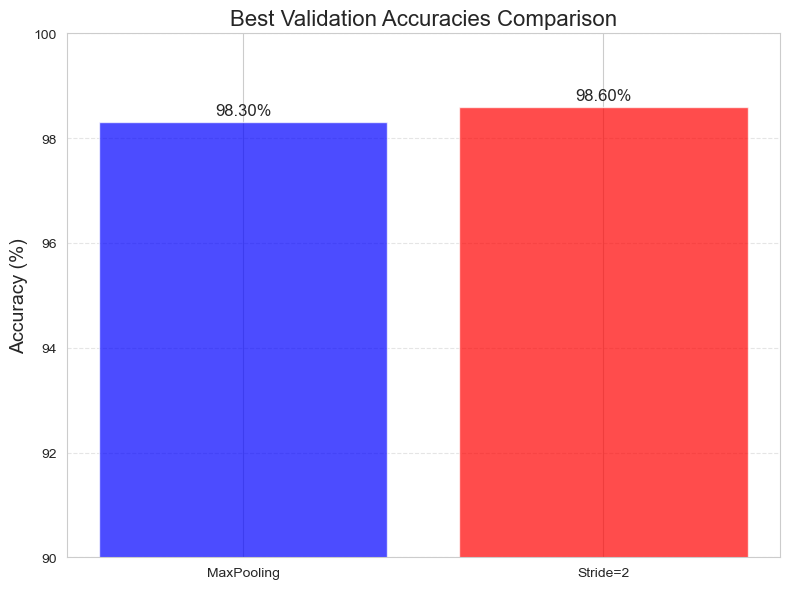

In [199]:
import matplotlib.pyplot as plt
import numpy as np

# Define the training steps
steps = [500, 1000, 1500, 2000, 2500, 3000, 3500]

# Accuracies for Model with MaxPooling
maxpool_train_acc = [0.8431875, 0.9732448630136986, 0.97478125, 0.9827340182648402,
                     0.9880573248407644, 0.9860625, 0.9895694813829787]
maxpool_val_acc = [0.9715, 0.974, 0.978, 0.977, 0.983, 0.982, 0.981]

# Accuracies for Model with Stride=2
stride2_train_acc = [0.83584375, 0.967537100456621, 0.9711875, 0.9792023401826484,
                     0.9864649681528662, 0.9830625, 0.9878241356382979]
stride2_val_acc = [0.9535, 0.968, 0.9745, 0.981, 0.978, 0.985, 0.986]

# Convert accuracies to percentages for better readability
maxpool_train_acc_percent = [acc * 100 for acc in maxpool_train_acc]
maxpool_val_acc_percent = [acc * 100 for acc in maxpool_val_acc]

stride2_train_acc_percent = [acc * 100 for acc in stride2_train_acc]
stride2_val_acc_percent = [acc * 100 for acc in stride2_val_acc]
# Plotting for MaxPooling Model
plt.figure(figsize=(12, 6))
plt.plot(steps, maxpool_train_acc_percent, marker='o', label='Training Accuracy', color='blue')
plt.plot(steps, maxpool_val_acc_percent, marker='s', label='Validation Accuracy', color='cyan')
plt.title('MaxPooling Model: Training and Validation Accuracies', fontsize=16)
plt.xlabel('Training Steps', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.xticks(steps)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()




# Plotting for Stride=2 Model
plt.figure(figsize=(12, 6))
plt.plot(steps, stride2_train_acc_percent, marker='o', label='Training Accuracy', color='red')
plt.plot(steps, stride2_val_acc_percent, marker='s', label='Validation Accuracy', color='orange')
plt.title('Stride=2 Model: Training and Validation Accuracies', fontsize=16)
plt.xlabel('Training Steps', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.xticks(steps)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Find the best validation accuracies
maxpool_best_val_acc = max(maxpool_val_acc_percent)
stride2_best_val_acc = max(stride2_val_acc_percent)

# Find the corresponding steps
maxpool_best_step = steps[maxpool_val_acc_percent.index(maxpool_best_val_acc)]
stride2_best_step = steps[stride2_val_acc_percent.index(stride2_best_val_acc)]

# Print the best accuracies
print(f"MaxPooling Model: Best Validation Accuracy = {maxpool_best_val_acc:.2f}% at Step {maxpool_best_step}")
print(f"Stride=2 Model: Best Validation Accuracy = {stride2_best_val_acc:.2f}% at Step {stride2_best_step}")


# Define the models and their best validation accuracies
models = ['MaxPooling', 'Stride=2']
best_val_acc = [maxpool_best_val_acc, stride2_best_val_acc]

# Colors for the bars
colors = ['blue', 'red']

# Create the bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(models, best_val_acc, color=colors, alpha=0.7)

# Add value labels on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}%',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom',
                 fontsize=12)

plt.title('Best Validation Accuracies Comparison', fontsize=16)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.ylim(90, 100)  # Adjust y-axis limits for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



# Question 5. - Dropout

Dropout is a very useful technique for preventing overfitting. Try to add a DropoutLayer after some of the convolution layers. You may observe a higher validation accuracy but lower train accuracy. Can you explain why this might be the case?

# Dropout after third and fourth convolution layer

In [215]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define hyperparameters for the convolutional layers
num_filters1 = 16
num_filters2 = 32
num_filters3 = 64
num_filters4 = 128

filter_size = 3
padding = 1  # To preserve spatial dimensions
stride_conv = 1  # Stride for convolutional layers
stride_pool = 2  # Stride for max-pooling layers
pool_kernel_size = 2  # Kernel size for max-pooling

channels = 1  # Input channels (e.g., grayscale images)
height = 28
width = 28
num_classes = 10

# Function to calculate output dimensions after Conv or Pool layers
def calculate_output_size(input_size, kernel_size, padding, stride):
    return (input_size - kernel_size + 2 * padding) // stride + 1

# Calculate output dimensions after each Conv + Pool layer
# After Conv Layer 1
output_height1 = calculate_output_size(height, filter_size, padding, stride_conv)
output_width1 = calculate_output_size(width, filter_size, padding, stride_conv)

# After MaxPool Layer 1
output_height1_pool = output_height1 // stride_pool
output_width1_pool = output_width1 // stride_pool

# After Conv Layer 2
output_height2 = calculate_output_size(output_height1_pool, filter_size, padding, stride_conv)
output_width2 = calculate_output_size(output_width1_pool, filter_size, padding, stride_conv)

# After MaxPool Layer 2
output_height2_pool = output_height2 // stride_pool
output_width2_pool = output_width2 // stride_pool

# After Conv Layer 3
output_height3 = calculate_output_size(output_height2_pool, filter_size, padding, stride_conv)
output_width3 = calculate_output_size(output_width2_pool, filter_size, padding, stride_conv)

# After MaxPool Layer 3
output_height3_pool = output_height3 // stride_pool
output_width3_pool = output_width3 // stride_pool

# After Conv Layer 4
output_height4 = calculate_output_size(output_height3_pool, filter_size, padding, stride_conv)
output_width4 = calculate_output_size(output_width3_pool, filter_size, padding, stride_conv)

# After MaxPool Layer 4
output_height4_pool = output_height4 // stride_pool
output_width4_pool = output_width4 // stride_pool

# Update n_features based on the final output dimensions
n_features = num_filters4 * output_height4_pool * output_width4_pool

print(f"Final feature map size: {num_filters4} channels, {output_height4_pool}x{output_width4_pool}")
print(f"n_features: {n_features}")

class PrintSize(nn.Module):
    """Utility module to print the current shape of a Tensor in Sequential, only on the first forward pass."""
    def __init__(self):
        super(PrintSize, self).__init__()
        self.first = True
        
    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        activation_fn = nn.ReLU
        dropout_rate = 0.5  # Dropout sandsynlighed
        
        self.net = nn.Sequential(
            PrintSize(),
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1, stride=1),  # Conv Layer 1
            activation_fn(),
            #nn.Dropout(dropout_rate),
            nn.MaxPool2d(kernel_size=2, stride=2),
            PrintSize(),
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),  # Conv Layer 2
            activation_fn(),
            nn.Dropout(dropout_rate),
            nn.MaxPool2d(kernel_size=2, stride=2),
            PrintSize(),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),  # Conv Layer 3
            activation_fn(),
            nn.Dropout(dropout_rate),
            nn.MaxPool2d(kernel_size=2, stride=2),
            PrintSize(),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),  # Conv Layer 4
            activation_fn(),
           # nn.Dropout(dropout_rate),
            nn.MaxPool2d(kernel_size=2, stride=2),
            PrintSize(),
            
            nn.Flatten(),  # Converts (batch_size, channels, height, width) to (batch_size, channels * height * width)
            nn.Linear(n_features, 128),
            activation_fn(),
            nn.Linear(128, 128),
            activation_fn(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# Instantiate the model
model = Model()
print(model)

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)



Final feature map size: 128 channels, 1x1
n_features: 128
Model(
  (net): Sequential(
    (0): PrintSize()
    (1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): PrintSize()
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): PrintSize()
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Dropout(p=0.5, inplace=False)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): PrintSize()
    (15): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (18): PrintSize()
    (19): Flatten(star

# Dropout after the first and second convolution layer

# The loop

In [216]:
batch_size = 64
num_epochs = 5
validation_every_steps = 500

train_set = TensorDataset(x_train, targets_train)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
valid_set = TensorDataset(x_valid, targets_valid)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, drop_last=False)
test_set = TensorDataset(x_test, targets_test)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=False)

step = 0
model.train()

train_accuracies = []
valid_accuracies = []
        
for epoch in range(num_epochs):
    
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        
        # Forward pass.
        output = model(inputs)
        
        # Compute loss.
        loss = loss_fn(output, targets)
        
        # Clean up gradients from the model.
        optimizer.zero_grad()
        
        # Compute gradients based on the loss from the current batch (backpropagation).
        loss.backward()
        
        # Take one optimizer step using the gradients computed in the previous step.
        optimizer.step()
        
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy_score(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in valid_loader:
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy_score(targets, predictions) * len(inputs))

                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(x_valid))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             validation accuracy: {valid_accuracies[-1]}")


print("Finished training.")

Size: torch.Size([64, 1, 28, 28])
Size: torch.Size([64, 16, 14, 14])
Size: torch.Size([64, 32, 7, 7])
Size: torch.Size([64, 64, 3, 3])
Size: torch.Size([64, 128, 1, 1])
Step 500     training accuracy: 0.795875
             validation accuracy: 0.954
Step 1000    training accuracy: 0.9533390410958904
             validation accuracy: 0.974
Step 1500    training accuracy: 0.9603125
             validation accuracy: 0.981
Step 2000    training accuracy: 0.9688213470319634
             validation accuracy: 0.982
Step 2500    training accuracy: 0.9726313694267515
             validation accuracy: 0.983
Step 3000    training accuracy: 0.9736875
             validation accuracy: 0.984
Step 3500    training accuracy: 0.974858710106383
             validation accuracy: 0.9815
Finished training.


# Svar til Q5)

1. Dropout er en regulariseringsteknik, der hjælper med at forhindre overfitting ved midlertidigt at deaktivere en tilfældig procentdel af neuronerne under træning. Når du tilføjer Dropout-lag efter konvolutionslagene, påvirker det modellens evne til at lære komplekse mønstre fra træningsdataene. Her er hvorfor du kan observere højere valideringsnøjagtighed men lavere træningsnøjagtighed:

## **Reduceret Overfitting:**

1. Træningsnøjagtighed: Da Dropout deaktiverer neuroner tilfældigt, bliver modellen "dårligere" til at tilpasse sig præcist til træningsdataene. Dette kan resultere i en lavere træningsnøjagtighed, da modellen ikke kan "huske" træningsdataene fuldstændigt.

2. Valideringsnøjagtighed: Dropout tvinger modellen til at generalisere bedre ved at forhindre, at den bliver for afhængig af specifikke neuroner eller mønstre i træningsdataene. Dette kan føre til en højere valideringsnøjagtighed, da modellen fungerer bedre på usete data

# **Results of Q5) - Maxpool**
## Dropout = 0.5 with dropout after every convolution layer

Size: torch.Size([64, 1, 28, 28])
Size: torch.Size([64, 16, 14, 14])
Size: torch.Size([64, 32, 7, 7])
Size: torch.Size([64, 64, 3, 3])
Size: torch.Size([64, 128, 1, 1])
Step 500     training accuracy: 0.73278125
             validation accuracy: 0.949
Step 1000    training accuracy: 0.9354309360730594
             validation accuracy: 0.959
Step 1500    training accuracy: 0.94509375
             validation accuracy: 0.956
Step 2000    training accuracy: 0.9515910388127854
             validation accuracy: 0.9705
Step 2500    training accuracy: 0.9626791401273885
             validation accuracy: 0.9795
Step 3000    training accuracy: 0.96028125
             validation accuracy: 0.9755
Step 3500    training accuracy: 0.964345079787234
             validation accuracy: 0.9785


## Dropout = 0.5 with dropout after convolution layer 1. and 2.

Size: torch.Size([64, 1, 28, 28])
Size: torch.Size([64, 16, 14, 14])
Size: torch.Size([64, 32, 7, 7])
Size: torch.Size([64, 64, 3, 3])
Size: torch.Size([64, 128, 1, 1])
Step 500     training accuracy: 0.82665625
             validation accuracy: 0.966
Step 1000    training accuracy: 0.9644691780821918
             validation accuracy: 0.977
Step 1500    training accuracy: 0.967875
             validation accuracy: 0.981
Step 2000    training accuracy: 0.9740653538812786
             validation accuracy: 0.985
Step 2500    training accuracy: 0.9782046178343949
             validation accuracy: 0.9855
Step 3000    training accuracy: 0.97925
             validation accuracy: 0.983
Step 3500    training accuracy: 0.9822972074468085
             validation accuracy: 0.9855
Finished training.


## Dropout = 0.5 with dropout after convolution layer 3. and 4.

Size: torch.Size([64, 1, 28, 28])
Size: torch.Size([64, 16, 14, 14])
Size: torch.Size([64, 32, 7, 7])
Size: torch.Size([64, 64, 3, 3])
Size: torch.Size([64, 128, 1, 1])
Step 500     training accuracy: 0.74315625
             validation accuracy: 0.964
Step 1000    training accuracy: 0.948416095890411
             validation accuracy: 0.9685
Step 1500    training accuracy: 0.95921875
             validation accuracy: 0.9805
Step 2000    training accuracy: 0.967394406392694
             validation accuracy: 0.986
Step 2500    training accuracy: 0.973328025477707
             validation accuracy: 0.9835
Step 3000    training accuracy: 0.9748125
             validation accuracy: 0.983
Step 3500    training accuracy: 0.9752742686170213
             validation accuracy: 0.989

## Dropout = 0.5 with dropout after convolution layer 2. and 3.

Size: torch.Size([64, 1, 28, 28])
Size: torch.Size([64, 16, 14, 14])
Size: torch.Size([64, 32, 7, 7])
Size: torch.Size([64, 64, 3, 3])
Size: torch.Size([64, 128, 1, 1])
Step 500     training accuracy: 0.795875
             validation accuracy: 0.954
Step 1000    training accuracy: 0.9533390410958904
             validation accuracy: 0.974
Step 1500    training accuracy: 0.9603125
             validation accuracy: 0.981
Step 2000    training accuracy: 0.9688213470319634
             validation accuracy: 0.982
Step 2500    training accuracy: 0.9726313694267515
             validation accuracy: 0.983
Step 3000    training accuracy: 0.9736875
             validation accuracy: 0.984
Step 3500    training accuracy: 0.974858710106383
             validation accuracy: 0.9815

1. Dropout efter alle konvolutionslag: Bedste Valideringsnøjagtighed = 97.95% ved Step 2500
2. Dropout efter konvolutionslag 1 og 2: Bedste Valideringsnøjagtighed = 98.55% ved Step 2500
3. Dropout efter konvolutionslag 3 og 4: Bedste Valideringsnøjagtighed = 98.90% ved Step 3500
4. Dropout efter konvolutionslag 2 og 3: Bedste Valideringsnøjagtighed = 98.40% ved Step 3000


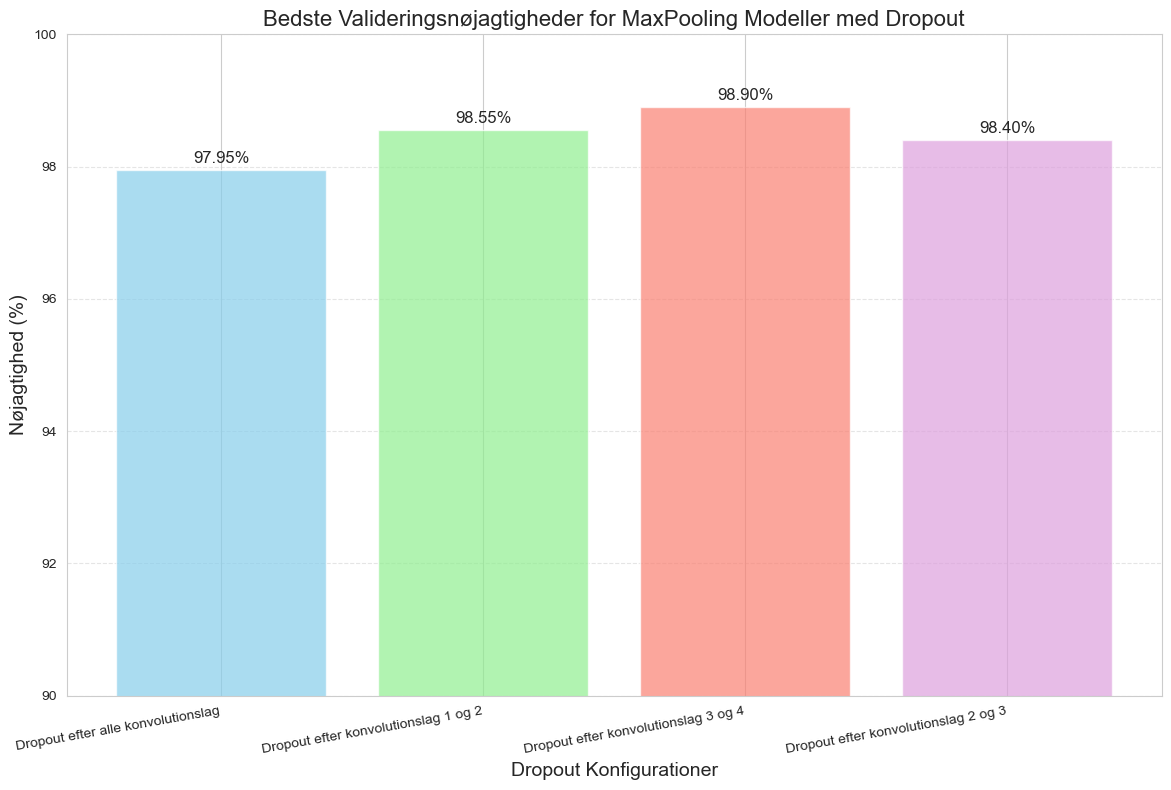

In [218]:
import matplotlib.pyplot as plt
import numpy as np

# Definer trænings trin
steps = [500, 1000, 1500, 2000, 2500, 3000, 3500]

# Valideringsnøjagtigheder for MaxPooling Modeller med forskellige Dropout-konfigurationer

# 1. Dropout efter alle konvolutionslag
maxpool_dropout_every_conv_val_acc = [0.949, 0.959, 0.956, 0.9705, 0.9795, 0.9755, 0.9785]

# 2. Dropout efter konvolutionslag 1 og 2
maxpool_dropout_conv1_2_val_acc = [0.966, 0.977, 0.981, 0.985, 0.9855, 0.983, 0.9855]

# 3. Dropout efter konvolutionslag 3 og 4
maxpool_dropout_conv3_4_val_acc = [0.964, 0.9685, 0.9805, 0.986, 0.9835, 0.983, 0.989]

# 4. Dropout efter konvolutionslag 2 og 3
maxpool_dropout_conv2_3_val_acc = [0.954, 0.974, 0.981, 0.982, 0.983, 0.984, 0.9815]

# Find den bedste valideringsnøjagtighed for hver konfiguration
best_val_acc_every_conv = max(maxpool_dropout_every_conv_val_acc) * 100  # Konverter til %
best_val_acc_conv1_2 = max(maxpool_dropout_conv1_2_val_acc) * 100
best_val_acc_conv3_4 = max(maxpool_dropout_conv3_4_val_acc) * 100
best_val_acc_conv2_3 = max(maxpool_dropout_conv2_3_val_acc) * 100

# Find de tilsvarende trin for de bedste valideringsnøjagtigheder
best_step_every_conv = steps[maxpool_dropout_every_conv_val_acc.index(max(maxpool_dropout_every_conv_val_acc))]
best_step_conv1_2 = steps[maxpool_dropout_conv1_2_val_acc.index(max(maxpool_dropout_conv1_2_val_acc))]
best_step_conv3_4 = steps[maxpool_dropout_conv3_4_val_acc.index(max(maxpool_dropout_conv3_4_val_acc))]
best_step_conv2_3 = steps[maxpool_dropout_conv2_3_val_acc.index(max(maxpool_dropout_conv2_3_val_acc))]

# Udskriv de bedste valideringsnøjagtigheder
print(f"1. Dropout efter alle konvolutionslag: Bedste Valideringsnøjagtighed = {best_val_acc_every_conv:.2f}% ved Step {best_step_every_conv}")
print(f"2. Dropout efter konvolutionslag 1 og 2: Bedste Valideringsnøjagtighed = {best_val_acc_conv1_2:.2f}% ved Step {best_step_conv1_2}")
print(f"3. Dropout efter konvolutionslag 3 og 4: Bedste Valideringsnøjagtighed = {best_val_acc_conv3_4:.2f}% ved Step {best_step_conv3_4}")
print(f"4. Dropout efter konvolutionslag 2 og 3: Bedste Valideringsnøjagtighed = {best_val_acc_conv2_3:.2f}% ved Step {best_step_conv2_3}")

# Definer konfigurationer og deres bedste valideringsnøjagtigheder
configs = [
    'Dropout efter alle konvolutionslag',
    'Dropout efter konvolutionslag 1 og 2',
    'Dropout efter konvolutionslag 3 og 4',
    'Dropout efter konvolutionslag 2 og 3'
]

best_val_accuracies = [
    best_val_acc_every_conv,
    best_val_acc_conv1_2,
    best_val_acc_conv3_4,
    best_val_acc_conv2_3
]

# Farver til søjlerne
colors = ['skyblue', 'lightgreen', 'salmon', 'plum']

# Opret søjlediagrammet
plt.figure(figsize=(12, 8))
bars = plt.bar(configs, best_val_accuracies, color=colors, alpha=0.7)

# Tilføj værdietiketter oven på søjlerne
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 punkters vertikal offset
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=12)

# Tilføj titel og akseetiketter
plt.title('Bedste Valideringsnøjagtigheder for MaxPooling Modeller med Dropout', fontsize=16)
plt.xlabel('Dropout Konfigurationer', fontsize=14)
plt.ylabel('Nøjagtighed (%)', fontsize=14)
plt.ylim(90, 100)  # Juster y-aksen for bedre visualisering

# Tilføj grid for bedre læsbarhed
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Rotér x-etiketter hvis nødvendigt
plt.xticks(rotation=10, ha='right')

plt.tight_layout()
plt.show()




# Question 6. - Batch normalization


Batch normalization may help convergence in larger networks as well as generalization performance. Try to insert batch normalization layers into the network.

# The model

In [225]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define hyperparameters for the convolutional layers
num_filters1 = 16
num_filters2 = 32
num_filters3 = 64
num_filters4 = 128

filter_size = 3
padding = 1  # To preserve spatial dimensions
stride_conv = 1  # Stride for convolutional layers
stride_pool = 2  # Stride for max-pooling layers
pool_kernel_size = 2  # Kernel size for max-pooling

channels = 1  # Input channels (e.g., grayscale images)
height = 28
width = 28
num_classes = 10

# Function to calculate output dimensions after Conv or Pool layers
def calculate_output_size(input_size, kernel_size, padding, stride):
    return (input_size - kernel_size + 2 * padding) // stride + 1

# Calculate output dimensions after each Conv + Pool layer
# After Conv Layer 1
output_height1 = calculate_output_size(height, filter_size, padding, stride_conv)
output_width1 = calculate_output_size(width, filter_size, padding, stride_conv)

# After MaxPool Layer 1
output_height1_pool = output_height1 // stride_pool
output_width1_pool = output_width1 // stride_pool

# After Conv Layer 2
output_height2 = calculate_output_size(output_height1_pool, filter_size, padding, stride_conv)
output_width2 = calculate_output_size(output_width1_pool, filter_size, padding, stride_conv)

# After MaxPool Layer 2
output_height2_pool = output_height2 // stride_pool
output_width2_pool = output_width2 // stride_pool

# After Conv Layer 3
output_height3 = calculate_output_size(output_height2_pool, filter_size, padding, stride_conv)
output_width3 = calculate_output_size(output_width2_pool, filter_size, padding, stride_conv)

# After MaxPool Layer 3
output_height3_pool = output_height3 // stride_pool
output_width3_pool = output_width3 // stride_pool

# After Conv Layer 4
output_height4 = calculate_output_size(output_height3_pool, filter_size, padding, stride_conv)
output_width4 = calculate_output_size(output_width3_pool, filter_size, padding, stride_conv)

# After MaxPool Layer 4
output_height4_pool = output_height4 // stride_pool
output_width4_pool = output_width4 // stride_pool

# Update n_features based on the final output dimensions
n_features = num_filters4 * output_height4_pool * output_width4_pool

print(f"Final feature map size: {num_filters4} channels, {output_height4_pool}x{output_width4_pool}")
print(f"n_features: {n_features}")

class PrintSize(nn.Module):
    """Utility module to print the current shape of a Tensor in Sequential, only on the first forward pass."""
    def __init__(self):
        super(PrintSize, self).__init__()
        self.first = True
        
    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        activation_fn = nn.ReLU
        dropout_rate = 0.7  # Dropout sandsynlighed
        
        self.net = nn.Sequential(
            PrintSize(),
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1, stride=1),  # Conv Layer 1
            #nn.BatchNorm2d(16),
            activation_fn(),
            #nn.Dropout(dropout_rate),
            nn.MaxPool2d(kernel_size=2, stride=2),
            PrintSize(),
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),  # Conv Layer 2
            nn.BatchNorm2d(32),
            activation_fn(),
            nn.Dropout(dropout_rate),
            nn.MaxPool2d(kernel_size=2, stride=2),
            PrintSize(),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),  # Conv Layer 3
            nn.BatchNorm2d(64),
            activation_fn(),
            nn.Dropout(dropout_rate),
            nn.MaxPool2d(kernel_size=2, stride=2),
            PrintSize(),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),  # Conv Layer 4
            nn.BatchNorm2d(128),
            activation_fn(),
           # nn.Dropout(dropout_rate),
            nn.MaxPool2d(kernel_size=2, stride=2),
            PrintSize(),
            
            nn.Flatten(),  # Converts (batch_size, channels, height, width) to (batch_size, channels * height * width)
            nn.Linear(n_features, 128),
            activation_fn(),
            nn.Linear(128, 128),
            activation_fn(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# Instantiate the model
model = Model()
print(model)

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)



Final feature map size: 128 channels, 1x1
n_features: 128
Model(
  (net): Sequential(
    (0): PrintSize()
    (1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): PrintSize()
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout(p=0.7, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): PrintSize()
    (11): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): Dropout(p=0.7, inplace=False)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): PrintSize()
    (17): Conv2d(64, 128, kernel_size=(3, 3

# The loop

In [226]:
batch_size = 64
num_epochs = 5
validation_every_steps = 500

train_set = TensorDataset(x_train, targets_train)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
valid_set = TensorDataset(x_valid, targets_valid)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, drop_last=False)
test_set = TensorDataset(x_test, targets_test)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=False)

step = 0
model.train()

train_accuracies = []
valid_accuracies = []
        
for epoch in range(num_epochs):
    
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        
        # Forward pass.
        output = model(inputs)
        
        # Compute loss.
        loss = loss_fn(output, targets)
        
        # Clean up gradients from the model.
        optimizer.zero_grad()
        
        # Compute gradients based on the loss from the current batch (backpropagation).
        loss.backward()
        
        # Take one optimizer step using the gradients computed in the previous step.
        optimizer.step()
        
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy_score(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in valid_loader:
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy_score(targets, predictions) * len(inputs))

                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(x_valid))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             validation accuracy: {valid_accuracies[-1]}")


print("Finished training.")

Size: torch.Size([64, 1, 28, 28])
Size: torch.Size([64, 16, 14, 14])
Size: torch.Size([64, 32, 7, 7])
Size: torch.Size([64, 64, 3, 3])
Size: torch.Size([64, 128, 1, 1])
Step 500     training accuracy: 0.85171875
             validation accuracy: 0.865
Step 1000    training accuracy: 0.9569777397260274
             validation accuracy: 0.9035
Step 1500    training accuracy: 0.96065625
             validation accuracy: 0.9375
Step 2000    training accuracy: 0.9661458333333334
             validation accuracy: 0.9285
Step 2500    training accuracy: 0.9690485668789809
             validation accuracy: 0.916
Step 3000    training accuracy: 0.97146875
             validation accuracy: 0.955
Step 3500    training accuracy: 0.9734873670212766
             validation accuracy: 0.877
Finished training.


# Svar på Q6)

Når både Batch Normalization og Dropout anvendes i samme model, kan de arbejde komplementært:

Batch Normalization stabiliserer træningen ved at normalisere input til hvert lag, hvilket tillader højere læringsrater og reducerer behovet for andre former for regularisering.

Dropout tilføjer yderligere regularisering ved at forhindre neuroner i at blive for afhængige af hinanden, hvilket kan forbedre modellens generalisering.



# **Results of Q5) - Maxpool and batchnorm**
## Dropout = 0.5 with dropout after 2 and 3 convolution layer and batchnorm after every convolution layer

Size: torch.Size([64, 1, 28, 28])
Size: torch.Size([64, 16, 14, 14])
Size: torch.Size([64, 32, 7, 7])
Size: torch.Size([64, 64, 3, 3])
Size: torch.Size([64, 128, 1, 1])
Step 500     training accuracy: 0.89896875
             validation accuracy: 0.929
Step 1000    training accuracy: 0.9733162100456622
             validation accuracy: 0.9495
Step 1500    training accuracy: 0.97525
             validation accuracy: 0.9755
Step 2000    training accuracy: 0.9795590753424658
             validation accuracy: 0.948
Step 2500    training accuracy: 0.9793988853503185
             validation accuracy: 0.979
Step 3000    training accuracy: 0.98259375
             validation accuracy: 0.967
Step 3500    training accuracy: 0.9842503324468085
             validation accuracy: 0.9785

## Dropout = 0.2 with dropout after 2 and 3 convolution layer and batchnorm after every convolution layer

Size: torch.Size([64, 1, 28, 28])
Size: torch.Size([64, 16, 14, 14])
Size: torch.Size([64, 32, 7, 7])
Size: torch.Size([64, 64, 3, 3])
Size: torch.Size([64, 128, 1, 1])
Step 500     training accuracy: 0.9296875
             validation accuracy: 0.972
Step 1000    training accuracy: 0.9830907534246576
             validation accuracy: 0.98
Step 1500    training accuracy: 0.9835625
             validation accuracy: 0.988
Step 2000    training accuracy: 0.9865154109589042
             validation accuracy: 0.986
Step 2500    training accuracy: 0.9890525477707006
             validation accuracy: 0.988
Step 3000    training accuracy: 0.98871875
             validation accuracy: 0.986
Step 3500    training accuracy: 0.9908577127659575
             validation accuracy: 0.9875


## Dropout = 0.7 with dropout after 2 and 3 convolution layer and batchnorm after every convolution layer

Size: torch.Size([64, 1, 28, 28])
Size: torch.Size([64, 16, 14, 14])
Size: torch.Size([64, 32, 7, 7])
Size: torch.Size([64, 64, 3, 3])
Size: torch.Size([64, 128, 1, 1])
Step 500     training accuracy: 0.85171875
             validation accuracy: 0.865
Step 1000    training accuracy: 0.9569777397260274
             validation accuracy: 0.9035
Step 1500    training accuracy: 0.96065625
             validation accuracy: 0.9375
Step 2000    training accuracy: 0.9661458333333334
             validation accuracy: 0.9285
Step 2500    training accuracy: 0.9690485668789809
             validation accuracy: 0.916
Step 3000    training accuracy: 0.97146875
             validation accuracy: 0.955
Step 3500    training accuracy: 0.9734873670212766
             validation accuracy: 0.877


Dropout=0.5: Træningsnøjagtighed er højere end valideringsnøjagtighed ved trin [1000, 2000, 2500, 3000, 3500]
Dropout=0.2: Træningsnøjagtighed er højere end valideringsnøjagtighed ved trin [1000, 2000, 2500, 3000, 3500]
Dropout=0.7: Træningsnøjagtighed er højere end valideringsnøjagtighed ved trin [1000, 1500, 2000, 2500, 3000, 3500]


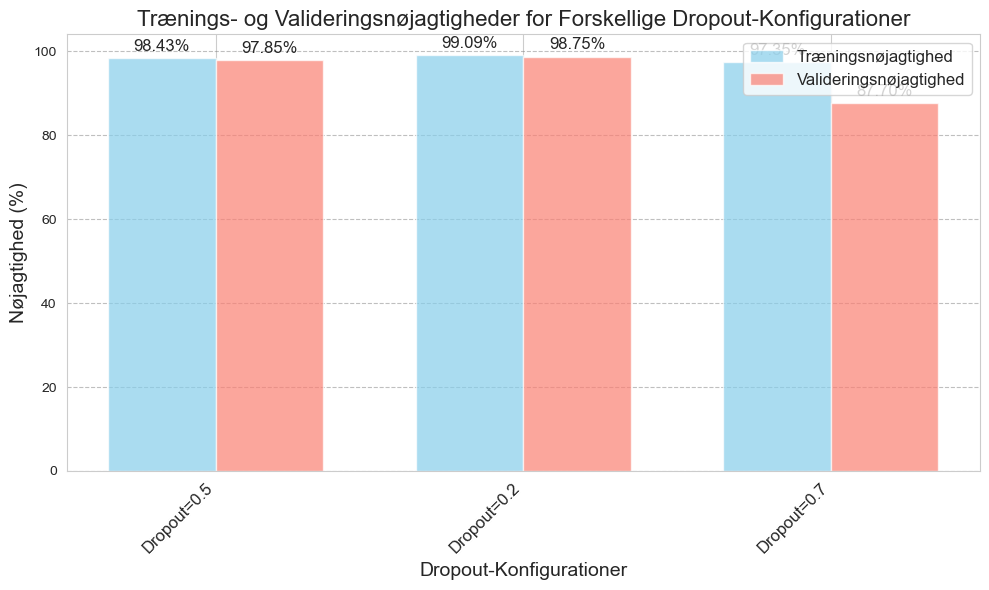

In [230]:
import matplotlib.pyplot as plt
import numpy as np

# Definer trænings trin
steps = [500, 1000, 1500, 2000, 2500, 3000, 3500]

# Valideringsnøjagtigheder for MaxPooling Modeller med forskellige Dropout-konfigurationer

# 1. Dropout = 0.5 efter konvolutionslag 2 og 3 med BatchNorm efter hvert konvolutionslag
dropout_0_5_val_acc = [0.929, 0.9495, 0.9755, 0.948, 0.979, 0.967, 0.9785]
dropout_0_5_train_acc = [0.89896875, 0.9733162100456622, 0.97525, 0.9795590753424658,
                         0.9793988853503185, 0.98259375, 0.9842503324468085]

# 2. Dropout = 0.2 efter konvolutionslag 2 og 3 med BatchNorm efter hvert konvolutionslag
dropout_0_2_val_acc = [0.972, 0.98, 0.988, 0.986, 0.988, 0.986, 0.9875]
dropout_0_2_train_acc = [0.9296875, 0.9830907534246576, 0.9835625, 0.9865154109589042,
                         0.9890525477707006, 0.98871875, 0.9908577127659575]

# 3. Dropout = 0.7 efter konvolutionslag 2 og 3 med BatchNorm efter hvert konvolutionslag
dropout_0_7_val_acc = [0.865, 0.9035, 0.9375, 0.9285, 0.916, 0.955, 0.877]
dropout_0_7_train_acc = [0.85171875, 0.9569777397260274, 0.96065625, 0.9661458333333334,
                         0.9690485668789809, 0.97146875, 0.9734873670212766]

# Organiser data i en dictionary for nem adgang
configs = {
    'Dropout=0.5': {
        'train_acc': dropout_0_5_train_acc,
        'val_acc': dropout_0_5_val_acc
    },
    'Dropout=0.2': {
        'train_acc': dropout_0_2_train_acc,
        'val_acc': dropout_0_2_val_acc
    },
    'Dropout=0.7': {
        'train_acc': dropout_0_7_train_acc,
        'val_acc': dropout_0_7_val_acc
    }
}


# Dictionary til at gemme trin hvor træning > validering for hver konfiguration
train_over_val_steps = {}

for config, data in configs.items():
    train_acc = data['train_acc']
    val_acc = data['val_acc']
    # Find indeks hvor træning > validering
    over_steps = [steps[i] for i in range(len(steps)) if train_acc[i] > val_acc[i]]
    train_over_val_steps[config] = over_steps


for config, steps_over in train_over_val_steps.items():
    if steps_over:
        print(f"{config}: Træningsnøjagtighed er højere end valideringsnøjagtighed ved trin {steps_over}")
    else:
        print(f"{config}: Træningsnøjagtighed er aldrig højere end valideringsnøjagtighed.")


# Konverter data til procent for bedre læsbarhed
for config, data in configs.items():
    data['train_acc_percent'] = [acc * 100 for acc in data['train_acc']]
    data['val_acc_percent'] = [acc * 100 for acc in data['val_acc']]

import matplotlib.pyplot as plt
import numpy as np

# Antal Dropout-konfigurationer
n_configs = len(configs)
configs_names = list(configs.keys())

# X-akse positioner
x = np.arange(n_configs)

# Bredde af søjlerne
width = 0.35  # bredde af hver søjle

# Initialiser figuren
fig, ax = plt.subplots(figsize=(10, 6))

# Hent trænings- og valideringsnøjagtigheder
train_acc = [configs[config]['train_acc_percent'][-1] for config in configs_names]  # sidste step
val_acc = [configs[config]['val_acc_percent'][-1] for config in configs_names]      # sidste step

# Opret søjler
bars1 = ax.bar(x - width/2, train_acc, width, label='Træningsnøjagtighed', color='skyblue', alpha=0.7)
bars2 = ax.bar(x + width/2, val_acc, width, label='Valideringsnøjagtighed', color='salmon', alpha=0.7)

# Tilføj etiketter og titel
ax.set_xlabel('Dropout-Konfigurationer', fontsize=14)
ax.set_ylabel('Nøjagtighed (%)', fontsize=14)
ax.set_title('Trænings- og Valideringsnøjagtigheder for Forskellige Dropout-Konfigurationer', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(configs_names, rotation=45, ha='right', fontsize=12)
ax.legend(fontsize=12)

# Tilføj grid
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)

# Tilføj værdietiketter oven på søjlerne
def autolabel(bars):
    """Vedhæft en tekstetiket oven på hver søjle, der viser dens højde"""
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 punkters vertikal offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=12)

autolabel(bars1)
autolabel(bars2)

plt.tight_layout()
plt.show()

